# ShoreLineNet ConvLSTM implementation

This notebook is a fork of "ShorelineNet" for the purpose of a 3rd year project at University College London. The original code is written for the conference paper "ShorelineNet: An Efficient Deep Learning Approach for Shoreline Semantic Segmentation for Unmanned Surface Vehicles" (Yao et al., 2021). 



To cite their conference paper please use the code below.

```
@inproceedings{yao2021shorelinenet,
  title={ShorelineNet: An Efficient Deep Learning Approach for Shoreline Semantic Segmentation for Unmanned Surface Vehicles},
  author={Yao, Linghong and Kanoulas, Dimitrios and Ji, Ze and Liu, Yuanchang},
  booktitle={Proceedings of the... IEEE/RSJ International Conference on Intelligent Robots and Systems. IEEE/RSJ International Conference on Intelligent Robots and Systems},
  year={2021},
  organization={IEEE}
}

```


## About 

This notebooks trains an image segementation network with modified MobileNetV2  + ConvLSTM UNet structure on the MaSTr1325 or MaSTr1478 dataset. The results are evaluated against the MODS benchmark (Bovcon et al., 2022) separately.

Find evaluation code here:  https://github.com/bborja/mods_evaluation

Find datasets here: https://box.vicos.si/borja/viamaro/index.html



## References

BOVCON, B., MUHOVIČ, J., VRANAC, D., MOZETIČ, D., PERŠ, J. & KRISTAN, M. 2022. MODS—A USV-Oriented Object Detection and Obstacle Segmentation Benchmark. IEEE Transactions on Intelligent Transportation Systems, 23, 13403-13418.

YAO, L., KANOULAS, D., JI, Z. & LIU, Y. ShorelineNet: An Efficient Deep Learning Approach for Shoreline Semantic Segmentation for Unmanned Surface Vehicles.  2021 IEEE/RSJ International Conference on Intelligent Robots and Systems (IROS), 27 Sept.-1 Oct. 2021 2021. 5403-5409.

### Misc. colab code

In [1]:
# When running on colab pro find GPU information with the following code from
# https://colab.research.google.com/notebooks/pro.ipynb
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

# And find available RAM:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Thu May 25 13:58:00 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    24W / 300W |      0MiB / 16384MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Mount on google drive for data

In [2]:
from google.colab import drive
drive.mount('/content/drive')

# Set path for drive with datasets
drive_path ="/content/drive/MyDrive/3rd_year_project_UCL"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Imports & Installs 


In [3]:
import sys
# Ensure newest version of pip and setuptools
!{sys.executable} -m pip install --upgrade pip setuptools
# Install tfds-nightly for upsampling layer
!{sys.executable} -m pip install -q git+https://github.com/tensorflow/examples.git
!{sys.executable} -m pip install -q -U tfds-nightly
# Install tfa for transformations
!{sys.executable} -m pip install -q -U tensorflow-addons
#  Install other modules
!{sys.executable} -m pip install tensorflow
!{sys.executable} -m pip install matplotlib
!{sys.executable} -m pip install pandas
!{sys.executable} -m pip install Pillow # NOTE: colab has a tendency to use outdated PIL, check version is >8.4 and restart runtime if wrong
!{sys.executable} -m pip install wget
!{sys.executable} -m pip install opencv-python
# Packages for MODS evaluation (future implementation)
!{sys.executable} -m pip install prettytable
!{sys.executable} -m pip install -U scikit-image
!{sys.executable} -m pip install ffmpeg-python
!{sys.executable} -m pip install yacs

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.d

In [4]:
import os
import re
import random
import time
import math
import datetime
import shutil

import tensorflow as tf
import tensorflow_addons as tfa

import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
import wget
import cv2

from PIL import Image as pimage 
from IPython.display import clear_output
# from tensorflow_examples.models.pix2pix import pix2pix

from tqdm.notebook import tqdm

from typing import Optional

AUTOTUNE = tf.data.experimental.AUTOTUNE

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [5]:
# Colab runs default pillow version 8.4 - should be 9.4. Restart runtime if not, that typically solves it
# E.g. see issue here  https://stackoverflow.com/questions/53237161/error-in-google-colaboratory-attributeerror-module-pil-image-has-no-attribu
import PIL
PIL.__version__

if PIL.__version__ == '8.4.0':
    raise SystemExit("Execution terminated: PIL version 8.4.0 detected")

<details>
<summary> EXPAND TO SEE REQUIRED PACKAGE VERSIONS </summary>

```
Package                       Version
----------------------------- ---------------------
absl-py                       1.4.0
alabaster                     0.7.13
albumentations                1.2.1
altair                        4.2.2
appdirs                       1.4.4
argon2-cffi                   21.3.0
argon2-cffi-bindings          21.2.0
array-record                  0.2.0
arviz                         0.15.1
astropy                       5.2.1
astunparse                    1.6.3
attrs                         22.2.0
audioread                     3.0.0
autograd                      1.5
Babel                         2.12.1
backcall                      0.2.0
beautifulsoup4                4.11.2
bleach                        6.0.0
blis                          0.7.9
bokeh                         2.4.3
branca                        0.6.0
CacheControl                  0.12.11
cached-property               1.5.2
cachetools                    5.3.0
catalogue                     2.0.8
certifi                       2022.12.7
cffi                          1.15.1
chardet                       3.0.4
charset-normalizer            2.0.12
chex                          0.1.6
click                         8.1.3
cloudpickle                   2.2.1
cmake                         3.25.2
cmdstanpy                     1.1.0
colorcet                      3.0.1
colorlover                    0.3.0
community                     1.0.0b1
confection                    0.0.4
cons                          0.4.5
contextlib2                   0.6.0.post1
contourpy                     1.0.7
convertdate                   2.4.0
cryptography                  39.0.2
cufflinks                     0.17.3
cupy-cuda11x                  11.0.0
cvxopt                        1.3.0
cvxpy                         1.3.1
cycler                        0.11.0
cymem                         2.0.7
Cython                        0.29.33
dask                          2022.12.1
datascience                   0.17.6
db-dtypes                     1.0.5
dbus-python                   1.2.16
debugpy                       1.6.6
decorator                     4.4.2
defusedxml                    0.7.1
distributed                   2022.12.1
dlib                          19.24.0
dm-tree                       0.1.8
docutils                      0.16
dopamine-rl                   4.0.6
earthengine-api               0.1.346
easydict                      1.10
ecos                          2.0.12
editdistance                  0.5.3
en-core-web-sm                3.5.0
entrypoints                   0.4
ephem                         4.1.4
et-xmlfile                    1.1.0
etils                         1.1.1
etuples                       0.3.8
exceptiongroup                1.1.1
fastai                        2.7.11
fastcore                      1.5.28
fastdownload                  0.0.7
fastjsonschema                2.16.3
fastprogress                  1.0.3
fastrlock                     0.8.1
ffmpeg-python                 0.2.0
filelock                      3.10.1
firebase-admin                5.3.0
Flask                         2.2.3
flatbuffers                   23.3.3
flax                          0.6.7
folium                        0.14.0
fonttools                     4.39.2
frozendict                    2.3.6
fsspec                        2023.3.0
future                        0.18.3
gast                          0.4.0
GDAL                          3.3.2
gdown                         4.6.4
gensim                        4.3.1
geographiclib                 2.0
geopy                         2.3.0
gin-config                    0.5.0
glob2                         0.7
google                        2.0.3
google-api-core               2.11.0
google-api-python-client      2.70.0
google-auth                   2.16.2
google-auth-httplib2          0.1.0
google-auth-oauthlib          0.4.6
google-cloud-bigquery         3.4.2
google-cloud-bigquery-storage 2.19.0
google-cloud-core             2.3.2
google-cloud-datastore        2.11.1
google-cloud-firestore        2.7.3
google-cloud-language         2.6.1
google-cloud-storage          2.7.0
google-cloud-translate        3.8.4
google-colab                  1.0.0
google-crc32c                 1.5.0
google-pasta                  0.2.0
google-resumable-media        2.4.1
googleapis-common-protos      1.59.0
googledrivedownloader         0.4
graphviz                      0.20.1
greenlet                      2.0.2
grpcio                        1.51.3
grpcio-status                 1.48.2
gspread                       3.4.2
gspread-dataframe             3.0.8
gym                           0.25.2
gym-notices                   0.0.8
h5netcdf                      1.1.0
h5py                          3.8.0
HeapDict                      1.0.1
hijri-converter               2.2.4
holidays                      0.21.13
holoviews                     1.15.4
html5lib                      1.1
htmlmin                       0.1.12
httpimport                    1.3.0
httplib2                      0.21.0
humanize                      4.6.0
hyperopt                      0.2.7
idna                          3.4
ImageHash                     4.3.1
imageio                       2.25.1
imageio-ffmpeg                0.4.8
imagesize                     1.4.1
imbalanced-learn              0.10.1
imgaug                        0.4.0
importlib-metadata            6.1.0
importlib-resources           5.12.0
imutils                       0.5.4
inflect                       6.0.2
iniconfig                     2.0.0
intel-openmp                  2023.0.0
ipykernel                     5.3.4
ipython                       7.9.0
ipython-genutils              0.2.0
ipython-sql                   0.4.1
ipywidgets                    7.7.1
itsdangerous                  2.1.2
jax                           0.4.6
jaxlib                        0.4.6+cuda11.cudnn86
jieba                         0.42.1
Jinja2                        3.1.2
joblib                        1.1.1
jsonschema                    4.3.3
jupyter-client                6.1.12
jupyter-console               6.1.0
jupyter_core                  5.3.0
jupyterlab-pygments           0.2.2
jupyterlab-widgets            3.0.6
kaggle                        1.5.13
keras                         2.11.0
keras-vis                     0.4.1
kiwisolver                    1.4.4
korean-lunar-calendar         0.3.1
langcodes                     3.3.0
lazy_loader                   0.2
libclang                      15.0.6.1
librosa                       0.10.0.post2
lightgbm                      3.3.5
llvmlite                      0.39.1
locket                        1.0.0
logical-unification           0.4.5
LunarCalendar                 0.0.9
lxml                          4.9.2
Markdown                      3.4.2
markdown-it-py                2.2.0
MarkupSafe                    2.1.2
matplotlib                    3.7.1
matplotlib-venn               0.11.9
mdurl                         0.1.2
miniKanren                    1.0.3
missingno                     0.5.2
mistune                       0.8.4
mizani                        0.8.1
mkl                           2019.0
mlxtend                       0.14.0
more-itertools                9.1.0
moviepy                       1.0.3
mpmath                        1.3.0
msgpack                       1.0.5
multimethod                   1.9.1
multipledispatch              0.6.0
multitasking                  0.0.11
murmurhash                    1.0.9
music21                       5.5.0
natsort                       5.5.0
nbclient                      0.7.2
nbconvert                     6.5.4
nbformat                      5.8.0
nest-asyncio                  1.5.6
networkx                      3.0
nibabel                       3.0.2
nltk                          3.8.1
notebook                      6.3.0
numba                         0.56.4
numexpr                       2.8.4
numpy                         1.22.4
oauth2client                  4.1.3
oauthlib                      3.2.2
opencv-contrib-python         4.7.0.72
opencv-python                 4.7.0.72
opencv-python-headless        4.7.0.72
openpyxl                      3.0.10
opt-einsum                    3.3.0
optax                         0.1.4
orbax                         0.1.6
osqp                          0.6.2.post0
packaging                     23.0
palettable                    3.3.0
pandas                        1.4.4
pandas-datareader             0.10.0
pandas-gbq                    0.17.9
pandas-profiling              3.2.0
pandocfilters                 1.5.0
panel                         0.14.4
param                         1.13.0
parso                         0.8.3
partd                         1.3.0
pathlib                       1.0.1
pathy                         0.10.1
patsy                         0.5.3
pep517                        0.13.0
pexpect                       4.8.0
phik                          0.12.3
pickleshare                   0.7.5
Pillow                        9.4.0
pip                           23.0.1
pip-tools                     6.6.2
platformdirs                  3.1.1
plotly                        5.13.1
plotnine                      0.10.1
pluggy                        1.0.0
pooch                         1.6.0
portpicker                    1.3.9
prefetch-generator            1.0.3
preshed                       3.0.8
prettytable                   0.7.2
proglog                       0.1.10
progressbar2                  3.38.0
prometheus-client             0.16.0
promise                       2.3
prompt-toolkit                2.0.10
prophet                       1.1.2
proto-plus                    1.22.2
protobuf                      3.19.6
psutil                        5.9.4
psycopg2                      2.9.5
ptyprocess                    0.7.0
py4j                          0.10.9.7
pyarrow                       9.0.0
pyasn1                        0.4.8
pyasn1-modules                0.2.8
pycocotools                   2.0.6
pycparser                     2.21
pyct                          0.5.0
pydantic                      1.10.7
pydata-google-auth            1.7.0
pydot                         1.4.2
pydot-ng                      2.0.0
pydotplus                     2.0.2
PyDrive                       1.3.1
pyerfa                        2.0.0.2
pygame                        2.3.0
Pygments                      2.14.0
PyGObject                     3.36.0
pymc                          5.1.2
PyMeeus                       0.5.12
pymystem3                     0.2.0
PyOpenGL                      3.1.6
pyparsing                     3.0.9
pyrsistent                    0.19.3
PySocks                       1.7.1
pytensor                      2.10.1
pytest                        7.2.2
python-apt                    0.0.0
python-dateutil               2.8.2
python-louvain                0.16
python-slugify                8.0.1
python-utils                  3.5.2
pytz                          2022.7.1
pytz-deprecation-shim         0.1.0.post0
pyviz-comms                   2.2.1
PyWavelets                    1.4.1
PyYAML                        6.0
pyzmq                         23.2.1
qdldl                         0.1.5.post3
qudida                        0.0.4
regex                         2022.10.31
requests                      2.27.1
requests-oauthlib             1.3.1
requests-unixsocket           0.2.0
rich                          13.3.2
rpy2                          3.5.5
rsa                           4.9
scikit-image                  0.20.0
scikit-learn                  1.2.2
scipy                         1.9.1
screen-resolution-extra       0.0.0
scs                           3.2.2
seaborn                       0.12.2
Send2Trash                    1.8.0
setuptools                    67.6.0
shapely                       2.0.1
six                           1.16.0
sklearn-pandas                2.2.0
smart-open                    6.3.0
snowballstemmer               2.2.0
sortedcontainers              2.4.0
soundfile                     0.12.1
soupsieve                     2.4
soxr                          0.3.4
spacy                         3.5.1
spacy-legacy                  3.0.12
spacy-loggers                 1.0.4
Sphinx                        3.5.4
sphinxcontrib-applehelp       1.0.4
sphinxcontrib-devhelp         1.0.2
sphinxcontrib-htmlhelp        2.0.1
sphinxcontrib-jsmath          1.0.1
sphinxcontrib-qthelp          1.0.3
sphinxcontrib-serializinghtml 1.1.5
SQLAlchemy                    1.4.47
sqlparse                      0.4.3
srsly                         2.4.6
statsmodels                   0.13.5
sympy                         1.11.1
tables                        3.7.0
tabulate                      0.8.10
tangled-up-in-unicode         0.2.0
tblib                         1.7.0
tenacity                      8.2.2
tensorboard                   2.11.2
tensorboard-data-server       0.6.1
tensorboard-plugin-wit        1.8.1
tensorflow                    2.11.0
tensorflow-addons             0.19.0
tensorflow-datasets           4.8.3
tensorflow-estimator          2.11.0
tensorflow-gcs-config         2.11.0
tensorflow-hub                0.13.0
tensorflow-io-gcs-filesystem  0.31.0
tensorflow-metadata           1.12.0
tensorflow-probability        0.19.0
tensorstore                   0.1.33
termcolor                     2.2.0
terminado                     0.17.1
text-unidecode                1.3
textblob                      0.17.1
tf-slim                       1.1.0
tfds-nightly                  4.8.3.dev202303270044
thinc                         8.1.9
threadpoolctl                 3.1.0
tifffile                      2023.3.21
tinycss2                      1.2.1
toml                          0.10.2
tomli                         2.0.1
toolz                         0.12.0
torch                         1.13.1+cu116
torchaudio                    0.13.1+cu116
torchsummary                  1.5.1
torchtext                     0.14.1
torchvision                   0.14.1+cu116
tornado                       6.2
tqdm                          4.65.0
traitlets                     5.7.1
tweepy                        4.13.0
typeguard                     3.0.2
typer                         0.7.0
typing_extensions             4.5.0
tzdata                        2022.7
tzlocal                       4.3
uritemplate                   4.1.1
urllib3                       1.26.15
vega-datasets                 0.9.0
visions                       0.7.4
wasabi                        1.1.1
wcwidth                       0.2.6
webencodings                  0.5.1
Werkzeug                      2.2.3
wget                          3.2
wheel                         0.40.0
widgetsnbextension            3.6.3
wordcloud                     1.8.2.2
wrapt                         1.15.0
xarray                        2022.12.0
xarray-einstats               0.5.1
xgboost                       1.7.4
xkit                          0.0.0
xlrd                          2.0.1
yacs                          0.1.8
yellowbrick                   1.5
yfinance                      0.2.13
zict                          2.2.0
zipp                          3.15.0
```

<details>

### Load data from google drive

In [46]:
# Set data pipline settings

Use_1478 = True # Use the full 1478 dataset with preceeding frames
Use_Preframes = False # Use the preceding frames in the MaSTr1478 dataset
Make_Preframes = False # Make artificial preceding frames
Num_Preframes = 1 # Number of preceding frames to use (either real or artificial)
Use_MODS = True # Import MODS dataset for future use in in-code evaluation CURRENTLY UNUSED IN THIS NOTEBOOK

**MasTr (1325 OR 1478) Dataset**

In [7]:
# Download data from Google drive

if 'data' not in os.listdir():
  if Use_1478:
    # !cp {drive_path+"/dataset/MaSTr1478.zip"} .  # The dataset with preceding frames is missing data for frame 0685 hence other ds
    # !unzip -q 'MaSTr1478.zip' -d data
    # !rm 'MaSTr1478.zip'
    !cp {drive_path+"/dataset/MaSTr1478_missing0685.zip"} .
    !unzip -q 'MaSTr1478_missing0685.zip' -d data
    !rm 'MaSTr1478_missing0685.zip'
  else:
    # !cp {drive_path+"/dataset/mastr.zip"} . # Use this to get the MaSTr1325 dataset without pre-frames
    # !unzip -q 'mastr.zip' -d data
    # !rm 'mastr.zip
    !cp {drive_path+"/dataset/mastr_Pref_missing0685.zip"} . # Preceding frames for the 1325 dataset taken from 1478 dataset
    !unzip -q 'mastr_Pref_missing0685.zip' -d data
    !rm 'mastr_Pref_missing0685.zip'



Training and cross validation datasets:
```
MaSTr1325
data
  - masks
  - images
  - pre_frames (from MaSTr1478)

Image names: 
  0001.jpg
  384 x 512 x 3
Annotation image names: 
  0001m.png
  384 x 512 x 1 (0: obstacle, 1: water, 2: sky)


MaSTr1478
data
  - masks
  - images
  - pre_frames

Image names: 
  0001.jpg with preceding images 0001_0.jpg to 0001_4.jpg
  384 x 512 x 3
Annotation image names: 
  0001m.jpg
  384 x 512 x 1 (0: obstacle, 1: water, 2: sky)

```



**MODD2 Dataset**

In [8]:
# Footage 1 to 28, can be used for preliminary evaluation in this notebook or extraction of results for separate evaluation in MATLAB
# Download data from colab
if 'eval_data' not in os.listdir():
  !cp {drive_path+"/dataset/eval_data_highres.zip"} .
  !unzip -q 'eval_data_highres.zip' -d eval_data
  !rm 'eval_data_highres.zip'


```
eval_data
  - images
  - masks
 
Image names: 
  27_001.jpg 
  128 x 128 x 3
Annotation image names: 
  27_001m.png
  128 x 128 x 1 (background-pixel = 0, sea-pixel = 1)
```



**MODS Dataset**

In [9]:
# MODS dataset for use in training and evaluation
# Available at https://github.com/bborja/mods_evaluation
# Download data from colab
if Use_MODS:
  if 'MODS' not in os.listdir():
    !cp {drive_path+"/dataset/MODS_images.zip"} .
    !unzip -q 'MODS_images.zip' -d MODS
    !rm 'MODS_images.zip'


```
Folder struct required for import

MODS/MODS_images/sequences/kope100-00006790-00007090/frames/00006790L.jpg etc.

Image names:
00006790L.jpg or R, stereo
1278x958x3 by default
```


### Dataset Pipeline - functions

1. `parse_image` : loads image & its corresponding label 
2. `normalize`: normalise input images and masks
3. `create_preframes`: create artificial pre-frames from transforms to original image
4. `load_image_train` and `load_image_test`: augmentation & normalize





In [10]:
def parse_image(img_path: str, HasMask = True, HasPreframes = False) -> dict:
    '''
    Loads the image and its mask, returns a dictionary

    Original      Returns
    0: obstacle   0: obstacle
    1: water      1: water
    2: sky        2: sky
    4: unknown    3: unknown

    Args
    ----------
    img_path : str
        Image filename pattern (glob)
        (Mask location is found using regex)

    Returns
    ----------
    dict {'image': tensor (384 x 512 x 3), 'mask': tensor (384 x 512 x 3)}
        Dictionary mapping an image and its annotation.
    '''

    # Read image
    image = tf.io.read_file(img_path)
    # Decode image into 3 channels for each pixel in uint8 format (RGB colours)
    image = tf.image.decode_jpeg(image, channels=3)
    # Convert image to uint8
    image = tf.image.convert_image_dtype(image, tf.dtypes.uint8)

    # For one Image path:
    # .../data/images/train/01_001.png
    # Its corresponding annotation path is:
    # .../data/annotations/train/01_001_label.png
    # Create mask path from image path as per default folder structure from download zip
    # .../ShorelineNet/MasTr1325_images_512x384
    # Becomes
    # .../ShorelineNet/MasTr1325_masks_512x384

    # Similarly, pre-frames have folder with "pre-frames" instead of images


    if HasMask and HasPreframes:
      mask_path = tf.strings.regex_replace(img_path, "images", "masks")
      mask_path = tf.strings.regex_replace(mask_path, ".jpg", "m.png")

      images = []
      preframes = []
      # If using preframes, create an array of these and append the image at the end for a full sequence
      for i in reversed(range(Num_Preframes)):
        preframe_path = tf.strings.regex_replace(img_path, "images", "pre_frames")
        preframe_path = tf.strings.regex_replace(preframe_path, ".jpg", ("_" + str(i) + ".jpg"))
        # Read preframe
        preframe = tf.io.read_file(preframe_path)
        # Decode image into 3 channels for each pixel in uint8 format (RGB colours)
        preframe = tf.image.decode_jpeg(preframe, channels=3)
        # Convert image to uint8
        preframe = tf.image.convert_image_dtype(preframe, tf.dtypes.uint8)
        preframes.append(preframe)
      images = preframes
      
      # Read mask path
      mask = tf.io.read_file(mask_path)
      # Decode mask to 1 channel in uint8
      mask = tf.image.decode_png(mask, channels=1, dtype=tf.dtypes.uint8) #+ 1
      # Redefine type 4 to 3 - unknown
      mask = tf.where(mask == 4, np.dtype('uint8').type(3), mask)
      # mask = tf.where(mask == 5, float(nan), mask )

      # Append image as the last of the sequence of preframes
      images.append(image)

      return {'image': images, 'mask': mask}

    elif HasMask:
      mask_path = tf.strings.regex_replace(img_path, "images", "masks")
      mask_path = tf.strings.regex_replace(mask_path, ".jpg", "m.png")

      # Read mask path
      mask = tf.io.read_file(mask_path)
      # Decode mask to 1 channel in uint8
      mask = tf.image.decode_png(mask, channels=1, dtype=tf.dtypes.uint8) #+ 1
      # Redefine type 4 to 3 - unknown
      mask = tf.where(mask == 4, np.dtype('uint8').type(3), mask)
      # mask = tf.where(mask == 5, float(nan), mask )

      return {'image': image, 'mask': mask}

    else:
      return {'image': image}


In [11]:
def normalize(input_image: tf.Tensor, input_mask: Optional[tf.Tensor] = None, input_preframes: Optional[tf.Tensor] = None, HasMask = True, HasPreframes = False) -> tuple:
    '''
    Rescale the pixel values of the images from [0, 255] to [0, 1]

    Args
    ----------
    input_image : tf.Tensor
        Tensorflow tensor containing an image of size [384,512,3].
    input_mask : tf.Tensor
        Tensorflow tensor containing an annotation of size [384,512,1].

    Returns
    ----------
    tuple
        Normalized image and its annotation.
    '''

    input_image = tf.cast(input_image, tf.float32) / 255.0
    if HasMask and HasPreframes:
      input_preframes = tf.cast(input_preframes, tf.float32) / 255.0
      input_mask = tf.cast(input_mask, tf.float32)
      return input_image, input_mask, input_preframes
    elif HasMask:
      input_mask = tf.cast(input_mask, tf.float32)
      return input_image, input_mask
    else:
      return input_image


In [12]:
def create_preframes(datapoint: dict, frames = 1) -> dict:
    '''
    Create number of preceding frames using pitch, roll, yaw and distortions
    in water

    Args
    ----------
    datapoint : dict
        A dict containing an image and its annotation.

    Returns
    ----------
    tuple
        A sequence of images and their annotations
    '''
    # INputs
    input_image = datapoint['image']
    input_mask = datapoint['mask']

    # frames is the number of pre-frames to create 
    output_images = [input_image for _ in range(frames+1)]
    output_masks = [input_mask for _ in range(frames+1)]
   
    
    p = random.uniform(-math.pi/90, math.pi/90) # Pitch angle/frame
    r = random.uniform(-math.pi/90, math.pi/90) # Roll angle/frame
    y = random.uniform(-math.pi/90, math.pi/90) # Yaw angle/frame
    w = random.uniform(0, 0.2) # Warping parameters UNUSED CURRENTLY

    
    # Roll pitch and yaw
    f = 1 # Approximate camera focal length

    # Translation of picture (to correct for focal length)
    dx = 0
    dy = 0
    dz = f

    for i in range(frames):
      alpha = r*(frames-i) # Angle about x-axis (pitch)
      beta = y*(frames-i) # Angle about y-axis (yaw)
      gamma = p*(frames-i) # Angle about z-axis (roll)

      # Define the rotation matrices
      r_x = np.array([[1, 0,             0,                 0],
                      [0, np.cos(alpha), -np.sin(alpha),    0],
                      [0, np.sin(alpha), np.cos(alpha),     0],
                      [0, 0,             0,                 1]])

      r_y = np.array([[np.cos(beta), 0,             -np.sin(beta),                 0],
                      [0,            1,             0,                             0],
                      [np.sin(beta), 0,             np.cos(beta),                  0],
                      [0,            0,             0,                             1]])

      r_z = np.array([[np.cos(gamma), -np.sin(gamma),             0,                 0],
                      [np.sin(gamma), np.cos(gamma),              0,                 0],
                      [0,             0,                          1,                 0],
                      [0,             0,                          0,                 1]])

      # Create full rotation matrix
      rot_matrix = r_x @ r_y @ r_z

      output_images[i] = tf.cast(output_images[i], dtype=tf.int32) # cast to int32
      output_masks[i] = tf.cast(output_masks[i], dtype=tf.int32) # cast to int32

      # Find image center
      height, width = 384, 512
      center = (width // 2, height // 2)

      # First translational matrix to move centre to origin
      trans1_matrix = np.array([[1, 0, -center[0], 0], [0, 1, -center[1], 0], [0, 0, 1, 0], [0, 0, 0, 1]])

      # Second translational matrix to move relative to camera position
      trans2_matrix = np.array([[1, 0, center[0], 0], [0, 1, center[1], 0], [0, 0, 1, 0], [0, 0, 0, 1]])

      # Projection matrix to move back to original position
      proj_matrix = np.array([[f, 0, center[0], 0], [0, f, center[1], 0], [0, 0, 1, 0], [0, 0, 0, 1]])

      # Compute the final transformation matrix
      trans_matrix = np.linalg.inv(proj_matrix) @ trans2_matrix @ rot_matrix @ trans1_matrix @ np.linalg.inv(proj_matrix)

      # Convert the transformation matrix to float data type
      trans_matrix = trans_matrix.astype(np.float32)

      # Create transformation vector
      Transform_vector = np.array([trans_matrix[0][0], trans_matrix[0][1], trans_matrix[0][3],
                                     trans_matrix[1][0], trans_matrix[1][1], trans_matrix[1][3],
                                     trans_matrix[3][0], trans_matrix[3][1]])

      # Create batch of projective transform matrices
      Transform_vector = np.tile(Transform_vector, (1, 1))
      Transform_vector = tf.convert_to_tensor(Transform_vector, dtype=tf.float32)

      # Reshape transforms to have shape (1, 8)
      Transform_vector = tf.reshape(Transform_vector, (1, 8))

      # Apply transform to images and masks
      output_images[i] = tfa.image.transform(output_images[i], Transform_vector, interpolation='BILINEAR')
      output_masks[i] = tfa.image.transform(output_masks[i], Transform_vector, interpolation='BILINEAR', fill_value = 3)

      # Cast to uint8
      output_images[i] = tf.cast(output_images[i], dtype=tf.uint8)
      output_masks[i] = tf.cast(output_masks[i], dtype=tf.uint8)

    return {'image': output_images, 'mask': output_masks[-1]} # Currently only ouput mask for final image as this is the current frame being segmented

In [13]:
def load_image_train(datapoint: dict) -> tuple:
    '''
    Apply some transformations to an input dictionary
    containing an image and its annotation.

    Note: should be applying to training set only

    Args
    ----------
    datapoint : dict
        A dict containing an image and its annotation.

    Returns
    ----------
    tuple
        A modified image and its annotation.
    '''
    # set input image and mask to data from disctionary input
    input_image = datapoint['image']
    input_mask = datapoint['mask']
      
    height, width = 384, 512

    # Flip half
    if tf.random.uniform(()) > 0.5:
      input_image = tf.image.flip_left_right(input_image)
      input_mask = tf.image.flip_left_right(input_mask)

    # Randomise hue, saturation, contrast and brightness
    if tf.random.uniform(()) > 0.2:

      h = random.uniform(0, 0.2)
      s = random.uniform(0.8, 1.2)
      c = random.uniform(0.6, 1.4)
      b = random.uniform(0, 0.2)

      input_image = tf.image.adjust_hue(input_image, h)
      input_image = tf.image.adjust_saturation(input_image, s)
      input_image = tf.image.adjust_contrast(input_image, c)
      input_image = tf.image.adjust_brightness(input_image, b)
      
      # input_image = tf.image.random_hue(input_image, 0.2)
      # input_image = tf.image.random_saturation(input_image, 0.8, 1.2)
      # input_image = tf.image.random_contrast(input_image, 0.6, 1.4)
      # input_image = tf.image.random_brightness(input_image, 0.2)
      

    # Rotation up to 22.5 deg either way
    if tf.random.uniform(()) > 0.2:
      alpha = tf.random.uniform((), -math.pi/8, math.pi/8) # random between -pi/8 and pi/8
      input_image = tfa.image.rotate(tf.cast(input_image, dtype=tf.int32), alpha) # cast to int32 and rotate by the random angle
      input_mask = tfa.image.rotate(tf.cast(input_mask, dtype=tf.int32), alpha, fill_value=3) # fills unknown data outside the boundaries after rotation
      # Recast to unit8
      input_image = tf.cast(input_image, dtype=tf.uint8)
      input_mask = tf.cast(input_mask, dtype=tf.uint8)
     
    # Scaling randomly between 70% and 90% of original size and fit at random location within bounding box
    if tf.random.uniform(()) > 0.2:
      crop_width = tf.random.uniform(shape=(), minval=math.floor(0.7 * width), maxval=math.floor(0.9 * width), dtype = tf.int32)
      crop_height = tf.random.uniform(shape=(), minval=math.floor(0.7 * height), maxval=math.floor(0.9 * height), dtype = tf.int32)

      offset_x = tf.random.uniform(shape=(), minval=0, maxval=(width - crop_width), dtype = tf.int32)
      offset_y = tf.random.uniform(shape=(), minval=0, maxval=(height - crop_height), dtype = tf.int32)

      input_image = tf.image.crop_to_bounding_box(input_image, offset_y, offset_x, crop_height, crop_width)
      input_mask = tf.image.crop_to_bounding_box(input_mask, offset_y, offset_x, crop_height, crop_width)
      
    # Resize image to given image size
    input_image = tf.image.resize(input_image, (IMG_SIZE, IMG_SIZE))
    input_mask = tf.image.resize(input_mask, (IMG_SIZE, IMG_SIZE), method='nearest')
 
    # Normalize & clip
    input_image, input_mask = normalize(input_image, input_mask) # Normalize by casting to float (and scaling by uint8 for image)

    input_image = tf.clip_by_value(input_image, clip_value_min=0., clip_value_max=1.) #Clip to maximum 1 and minimum 0

    return input_image, input_mask

In [14]:
def load_image_test(datapoint: dict, HasMask = True) -> tuple:
    '''
    Normalize and resize a test image and its annotation, no augmentation

    Note: 
      Applies to both validation and testing set

    Parameters
    ----------
    datapoint : dict
        A dict containing an image and its annotation.

    Returns
    -------
    tuple
        A modified image and its annotation.
    '''

    # Resize
    input_image = tf.image.resize(datapoint['image'], (IMG_SIZE, IMG_SIZE))
    if HasMask:
      input_mask = tf.image.resize(datapoint['mask'], (IMG_SIZE, IMG_SIZE))

      # Normalize
      input_image, input_mask = normalize(input_image, input_mask)

      return input_image, input_mask

    else:
      input_image = normalize(input_image, HasMask = False)

      return input_image

### Dataset Pipeline - execute

In [15]:
# Set square image size (square)
IMG_SIZE = 224
BATCH_SIZE = 64 
N_CLASSES = 3         # 0: obstacle, 1: water, 2: sky
TRAIN_VAL_RATIO = 0.90 # Within the MasTr dataset

# For reproducible result 
SEED = 321
# tf.random.set_seed(SEED)

In [16]:
# Set paths to file directories
data_dir = os.path.join(os.getcwd(), 'data/')
images_path = os.path.join(data_dir, 'images/') # MaSTr
labels_path = os.path.join(data_dir, 'masks/') # MaSTr

if Use_Preframes:
  pre_frames_path = os.path.join(data_dir, 'pre_frames/') # MaSTr

eval_data_dir = os.path.join(os.getcwd(), 'eval_data/') # MODD2
eval_images_path = os.path.join(eval_data_dir, 'images/')
eval_labels_path = os.path.join(eval_data_dir, 'masks/')

MODS_data_dir = os.path.join(os.getcwd(), 'MODS/') # MODS
MODS_images_path = os.path.join(MODS_data_dir, 'MODS_images/sequences/')

total_image_count = len(os.listdir(images_path))

print('total number of images:      {}'.format(total_image_count))

total number of images:      1477


In [17]:
# Get folder path lists for image sequences if used in LSTM
MODS_sequences = [ f.path for f in os.scandir(MODS_images_path) if f.is_dir() ]
eval_images_sequences = [ f.path for f in os.scandir(eval_images_path) if f.is_dir() ]
# test_sequence_folders use 'seq27' and 'seq28'
test_images_sequences = [item for item in eval_images_sequences if 'seq27' in item or 'seq28' in item]

In [18]:
# Get list of all image files in dataset list_dir - shuffle names randomly but use seed to get deterministic order for reproducibility
list_dir = tf.data.Dataset.list_files(images_path + '*.jpg', shuffle=True, seed=SEED)

# Test folders only sequence 27 and 28 - i.e. last two folders in import
test_sequence_folders = ['seq27', 'seq28'] # In eval data take 2 last folders for test ds
test_count_ds = tf.data.Dataset.list_files([eval_images_path + seq + '/*.jpg' for seq in test_sequence_folders], shuffle=False)

# Evaluation file dataset for all eval_images
eval_count_ds = tf.data.Dataset.list_files(eval_images_path + 'seq*' + '/*.jpg', shuffle=False)

# MODS evaluation ds
if Use_MODS:
  MODS_count_ds = tf.data.Dataset.list_files(MODS_images_path + '*' + '/frames' + '/*.jpg', shuffle=False)

# # Get list of file names for train and val - TRAIN_VAL_RATIO decides how many of the images are used for training and how many are used for validation
train_length = round(total_image_count * TRAIN_VAL_RATIO)
train_ds = list_dir.take(train_length)
val_ds = list_dir.skip(train_length)

# Get length of each dataset
TRAINSET_SIZE = tf.data.experimental.cardinality(train_ds).numpy() # size of dataset used to train (MasTr)
VALSET_SIZE = tf.data.experimental.cardinality(val_ds).numpy() # Size of dataset used to validate (MasTr)
TEST_SIZE = tf.data.experimental.cardinality(test_count_ds).numpy() # Size of dataset used to test (MODD2)
EVAL_SIZE = tf.data.experimental.cardinality(eval_count_ds).numpy() # Size of dataset used to evaluate (MODD2)
if Use_MODS:
  MODS_SIZE = tf.data.experimental.cardinality(MODS_count_ds).numpy() # Size of dataset used to evaluate (MODS)
else:
  MODS_SIZE = 0
print(f'Train: {TRAINSET_SIZE}, Val: {VALSET_SIZE}, Test: {TEST_SIZE}, Eval: {EVAL_SIZE}, MODS: {MODS_SIZE}')

Train: 1329, Val: 148, Test: 1292, Eval: 11703, MODS: 16350


In [19]:
# Run parse_image on all dataset entries
# Parses images to uint8 x3 RGB for images and x1 for masks of water, sky, obstacle and unknown
if Use_Preframes:
  train_ds = train_ds.map(lambda x: parse_image(x, HasPreframes = True))
  val_ds = val_ds.map(lambda x: parse_image(x, HasPreframes = True))
else:
  train_ds = train_ds.map(parse_image)
  val_ds = val_ds.map(parse_image)

if not (Use_Preframes or Make_Preframes): # If we are not using preframes take all files individually as we don't need sequences
    test_ds = test_count_ds.map(parse_image)
    eval_ds = eval_count_ds.map(parse_image)
    test_ds = test_ds.map(load_image_test, num_parallel_calls=AUTOTUNE) # Run test image load
    eval_ds = eval_ds.map(load_image_test, num_parallel_calls=AUTOTUNE) # Run eval image load

    if Use_MODS:
      MODS_ds = MODS_count_ds.map(lambda x: parse_image(x, HasMask = False))


If we use preframes we need to make small sequences of images of lenght (1+Num_Preframes). For each sequence folder in the MODD2 and MODS dataset we create Num_Preframes copies of the first image and apply a sliding window function to create small "video sequences" and store them in tensors (seq_lenght, 224, 224, 3)

In [20]:
if (Use_Preframes or Make_Preframes):

  # Eval DS
  temp = eval_count_ds.map(parse_image)
  temp = temp.map(load_image_test, num_parallel_calls=AUTOTUNE)
  temp = temp.map(lambda x, y: y) # Create dataset of just masks
  for i in eval_images_sequences:
    images_ds = tf.data.Dataset.list_files(i + '/*.jpg', shuffle=False)
    elem_list = list(images_ds)
    first_elem = elem_list[0]
    elem_list = [first_elem] * Num_Preframes + elem_list
    images_ds = tf.data.Dataset.from_tensor_slices(elem_list)
    images_ds = images_ds.map(lambda x: parse_image(x, HasMask = False))
    images_ds = images_ds.map(lambda x: load_image_test(x, HasMask = False), num_parallel_calls=AUTOTUNE) # Run eval image load
    images_ds = images_ds.window(Num_Preframes+1, shift=1, drop_remainder=True)
    images_ds = images_ds.flat_map(lambda window: window.batch(Num_Preframes+1))
    # images_ds.map(lambda x: tf.reshape(x, (Num_Preframes+1, 224, 224, 3)))
    if i == eval_images_sequences[0]:
      eval_ds = images_ds
    else:
      eval_ds.concatenate(images_ds)
    eval_ds= eval_ds.map(lambda x: tf.reshape(x, (Num_Preframes+1, 224, 224, 3)))
  eval_ds = tf.data.Dataset.zip((eval_ds, temp)) # Zip image sequence dataset with masks for the last image in each sequence

  # Test DS
  temp = test_count_ds.map(parse_image)
  temp = temp.map(load_image_test, num_parallel_calls=AUTOTUNE)
  temp = temp.map(lambda x, y: y) # Create dataset of just masks
  for i in test_images_sequences:
    images_ds = tf.data.Dataset.list_files(i + '/*.jpg', shuffle=False)
    elem_list = list(images_ds)
    first_elem = elem_list[0]
    elem_list = [first_elem] * Num_Preframes + elem_list
    images_ds = tf.data.Dataset.from_tensor_slices(elem_list)
    images_ds = images_ds.map(lambda x: parse_image(x, HasMask = False))
    images_ds = images_ds.map(lambda x: load_image_test(x, HasMask = False), num_parallel_calls=AUTOTUNE) # Run eval image load
    images_ds = images_ds.window(Num_Preframes+1, shift=1, drop_remainder=True)
    images_ds = images_ds.flat_map(lambda window: window.batch(Num_Preframes+1))
    # images_ds.map(lambda x: tf.reshape(x, (Num_Preframes+1, 224, 224, 3)))
    if i == test_images_sequences[0]:
      test_ds = images_ds
    else:
      test_ds.concatenate(images_ds)
    test_ds= test_ds.map(lambda x: tf.reshape(x, (Num_Preframes+1, 224, 224, 3)))
  test_ds = tf.data.Dataset.zip((test_ds, temp)) # Zip image sequence dataset with masks for the last image in each sequence

# MODS
  if Use_MODS: 
    for i in MODS_sequences:
      images_ds = tf.data.Dataset.list_files(i + '*' + '/frames' + '/*.jpg', shuffle=False)
      first_elem = elem_list[0]
      elem_list = [first_elem] * Num_Preframes + elem_list
      images_ds = tf.data.Dataset.from_tensor_slices(elem_list)
      images_ds = images_ds.map(lambda x: parse_image(x, HasMask = False))
      images_ds = images_ds.map(lambda x: load_image_test(x, HasMask = False), num_parallel_calls=AUTOTUNE) # Run eval image load
      images_ds = images_ds.window(Num_Preframes+1, shift=1, drop_remainder=True)
      images_ds = images_ds.flat_map(lambda window: window.batch(Num_Preframes+1))
      # images_ds.map(lambda x: tf.reshape(x, (Num_Preframes+1, 224, 224, 3)))
      if i == MODS_sequences[0]:
        MODS_ds = images_ds
      else:
        MODS_ds.concatenate(images_ds)
    MODS_ds= MODS_ds.map(lambda x: tf.reshape(x, (Num_Preframes+1, 224, 224, 3)))

In [21]:
# Training set:
# cache -> shuffle -> (make pre-frames) -> Augment -> batch -> repeat -> prefetch

# Validation set:
# cache -> shuffle -> (make pre-frames) -> batch -> prefetch

# Test & Eval sets:
# Resize -> batch

# MODS set:
# batch 

# Training set
train_ds = train_ds.cache() # cache dataset for it to be used over iterations
train_ds = train_ds.shuffle(buffer_size=1000) # Shuffle to ensure dataset is not in the same order on every iteration

# If necessary, make a set of fake preceding frames for the dataset
if Make_Preframes:
  train_ds = train_ds.map(lambda x: create_preframes(x, frames = Num_Preframes), num_parallel_calls=AUTOTUNE)

train_ds = train_ds.map(load_image_train, num_parallel_calls=AUTOTUNE) # applies load_image_train to all training images (preprocess)

train_ds = train_ds.batch(batch_size=BATCH_SIZE) # Batches training images into size 64 (as given above)
train_ds = train_ds.repeat() # Repeats dataset indefinitely to avoid errors
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE) # Allows prefetching of elements while later elements are prepared

# Validation dataset - apply the same augmentations, but use load_image_test to avoid applying augmentations
val_ds = val_ds.cache()
val_ds = val_ds.shuffle(buffer_size=1000) # Shuffle to ensure dataset is not in the same order on every iteration
if Make_Preframes:
  val_ds = val_ds.map(lambda x: create_preframes(x, frames = Num_Preframes), num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(load_image_test, num_parallel_calls=AUTOTUNE) # Run val image load
val_ds =val_ds.batch(batch_size=BATCH_SIZE)
val_ds =val_ds.prefetch(buffer_size=AUTOTUNE) # Cache batch prefetch

# test_ds and eval_ds is the MODD2 dataset used for later evaluation
test_ds = test_ds.cache().batch(batch_size = BATCH_SIZE) # Cache
eval_ds = eval_ds.batch(batch_size = BATCH_SIZE) # Batch

if Use_MODS:
  MODS_ds = MODS_ds.batch(batch_size = BATCH_SIZE) # Batch


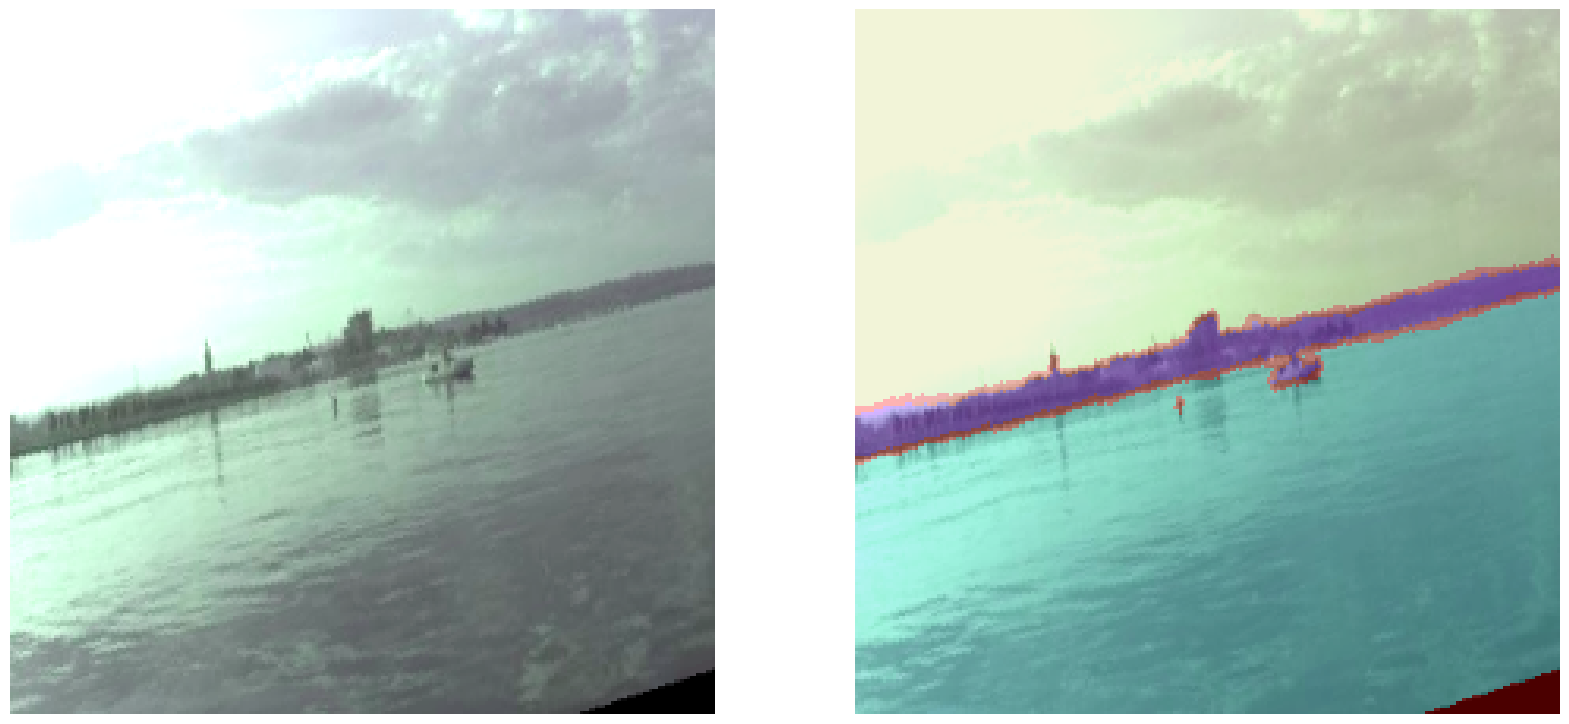

In [22]:
### Display images toi check they are loaded correctly

# train_ds.skip(37)

if Make_Preframes or Use_Preframes:
  for image_batch, mask_batch in train_ds.take(1): # Both a mask and an image batch stored in val_ds
    plt.figure(figsize=(20, 10)) # create 20 by 10 inch figure
    for i in range(Num_Preframes+1): # All pre-framess and current frame
      ax = plt.subplot(1, Num_Preframes+1, i+1) # Create subplot
      image = image_batch[0,i] 
      plt.imshow(image) # Plot image
      if i == Num_Preframes:
        mask = mask_batch[0] # For only the last image overlay its mask
        plt.imshow(tf.keras.preprocessing.image.array_to_img(mask), alpha=0.3, cmap='rainbow') # Convert mask to PIL, make transparent with alpha and apply colourmap
      plt.axis("off")
    break  
else:  
  for image_batch, mask_batch in val_ds.take(1): # Both a mask and an image batch stored in val_ds
    plt.figure(figsize=(10, 10)) # create 10 by 10 inch figure
    for i in range(9): # 0 through 8
      ax = plt.subplot(3, 3, i + 1) # Create subplot
      image = image_batch[i] 
      mask = mask_batch[i] # Take given image and mask
      plt.imshow(image) # Plot image
      plt.imshow(tf.keras.preprocessing.image.array_to_img(mask), alpha=0.3, cmap='rainbow') # Convert mask to PIL, make transparent with alpha and apply colourmap
      plt.axis("off")
    break

### Model Definition

In [23]:
tf.keras.backend.clear_session() # Clear the state and frees up memory

# Encoder
# base_model = tf.keras.applications.MobileNetV3Small(input_shape=[224, 224, 3], include_top=False, weights='imagenet')
base_model = tf.keras.applications.MobileNetV2(input_shape=[224, 224, 3], include_top=False) # Use MobileNetV2

# Extract the activations of these layers (relu)
layer_names = [
    'block_1_expand_relu',   # 64 x 64 x 96   --  112, 112, 96
    'block_3_expand_relu',   # 32 x 32 x 144  --  56, 56, 144
    'block_6_expand_relu',   # 16 x 16 x 192  --  28, 28, 192
    'block_13_expand_relu',  # 8  x 8  x 576  --  14, 14, 576
    'block_16_project',      # 4  x 4  x 320  --  7, 7, 320
]

layers = [base_model.get_layer(name).output for name in layer_names] # get all layers by the names given in layer_names

# # Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers) # create model (encoder stack) with outputs at certain levels given in layer_names
down_stack.trainable = False # Freeze parameters

9406464/9406464 [==============================] - 0s 0us/step


In [24]:
# If using preceding frames wrap the encoder in a TimeDistributed layer and take the last frame as output for skip connections

if Use_Preframes or Make_Preframes:
  def get_last_timestep(x): # This function is used to get the last timestep of feature maps not passing through convLSTM layers (e.g. skip connections)
      x_shape = tf.keras.backend.shape(x)
      input_length = x_shape[1]
      slices = [slice(None)] * tf.keras.backend.ndim(x)
      slices[1] = input_length - 1
      return x[slices]

  Batch_input = tf.keras.layers.Input(shape =(Num_Preframes+1, 224, 224, 3)) # Sequence input
  outputs = []
  for out in down_stack.output:
    outputs.append(tf.keras.layers.TimeDistributed(tf.keras.Model(base_model.input, out))(Batch_input))

  Time_model_skips = tf.keras.Model(inputs=Batch_input, outputs=outputs) # Entire decoder wrapped in timeDistributed layer - all skip connection outputs contain full sequence.

  for i in range(len(outputs[:-1])):
    outputs[i] = tf.keras.layers.Lambda(get_last_timestep, output_shape=lambda s: s[:1] + s[2:])(outputs[i])

  Time_model = tf.keras.Model(inputs=Batch_input, outputs=outputs) # Model where only the deepest layer has timeDistributed output of all seqence steps

In [25]:
def deconv_block(filters, size, norm_type='batchnorm', dropout_rate = 0.5):
  '''
  Conv2DTranspose => Batchnorm => Dropout => Relu
  '''
  initializer = tf.random_normal_initializer(0., 0.02) # Initialises value randomly from normal distribution
  result = tf.keras.Sequential() # groups layers to stack (creates stack here)
  result.add(
      tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                      padding='same',
                                      kernel_initializer=tf.keras.initializers.GlorotNormal(),
                                      use_bias=False)) # Adds deconvolutional layer

  result.add(tf.keras.layers.BatchNormalization()) # adds batch normalisation layer
  result.add(tf.keras.layers.Dropout(dropout_rate)) # Dropout
  result.add(tf.keras.layers.ReLU()) # Add activation function
  return result # Spit out upsampling block

In [26]:
# Decoder
up_stack = [
    deconv_block(512, 3, dropout_rate = 0.5),  # 4x4 -> 8x8
    deconv_block(256, 3, dropout_rate = 0.4),  # 8x8 -> 16x16
    deconv_block(128, 3, dropout_rate = 0.3),  # 16x16 -> 32x32
    deconv_block(64, 3, dropout_rate = 0.2),   # 32x32 -> 64x64
] # Create decoder from 4 upsampling blocks of each the layers in devonv_block

In [27]:
def unet_model(output_channels): # Standard ShorelineNet model
  ''' Instantiate a new instance of UNet Model '''
  inputs = tf.keras.layers.Input(shape=[224, 224, 3])
  x = inputs

  # Downsampling through the model
  skips = down_stack(x)
  x = skips[-1] # Deepest layer
  skips = reversed(skips[:-1]) # Skip connections from bottom up

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x) # Add decoder layer
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip]) # Concatenate with skip connection

  # Las model layer (deconvolution)
  last = tf.keras.layers.Conv2DTranspose(
      output_channels, 3, strides=2,
      padding='same')  #64x64 -> 128x128

  x = last(x) # Apply the last layer

  return tf.keras.Model(inputs=inputs, outputs=x)


In [28]:
def unet_model_LSTM_deep(output_channels): # Default ConvLSTM model with 1 convLSTM block at deepest level
  ''' Instantiate a new instance of ShorelineNet_ConvLSTM '''
  inputs = tf.keras.layers.Input(shape =(Num_Preframes+1, 224, 224, 3))
  x = inputs # Instantiate keras tensor
  skips = Time_model(x) # Encoder is time-distributed
  x = skips[-1] # Last layer

  # Define ConvLSTM layer
  ConvLSTM = tf.keras.layers.ConvLSTM2D(filters=x.shape[-1], kernel_size=(3, 3),
                                        data_format='channels_last',
                                        activation='tanh',
                                        padding='same', return_sequences=False,
                                        dropout = 0.1)
  
  # Batch normalisation layer
  Batch_Norm = tf.keras.layers.BatchNormalization()

  # Add layers
  x = ConvLSTM(x)
  x = Batch_Norm(x)

  skips = reversed(skips[:-1]) # Run through from last to first

  # Concatenate skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # deconvolution
  last = tf.keras.layers.Conv2DTranspose(
      output_channels, 3, strides=2,
      padding='same')  #64x64 -> 128x128

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)  

In [29]:
def unet_model_LSTM_end(output_channels): # Single ConvLSTM layer at the very end - is made as usual and timDistributed is added later
  ''' Instantiate a new instance of ShorelineNet-ConvLSTM_end '''
  inputs = tf.keras.layers.Input(shape=[224, 224, 3])
  x = inputs # Instantiate keras tensor

  # Downsampling through the model
  skips = down_stack(x)
  x = skips[-1] # Last layer

  skips = reversed(skips[:-1]) # Run through from last to first

  # Upsampling and establishing the skip connections

  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # deconvolution
  last = tf.keras.layers.Conv2DTranspose(
      output_channels, 3, strides=2,
      padding='same')  #64x64 -> 128x128

  x = last(x)
  outputs = x

  return tf.keras.Model(inputs=inputs, outputs=outputs)  

In [30]:
def unet_model_LSTM_deepend(output_channels): # Both a convLSTM block at the deepest level and at the end of the model
  ''' Instantiate a new instance of ShorelineNet-ConvLSTM_Deep_end '''

  inputs = tf.keras.layers.Input(shape =(Num_Preframes+1, 224, 224, 3))
  x = inputs # Instantiate keras tensor

  skips = Time_model_skips(x) # Time distributed model with skip connections also containing full sequence
  x = skips[-1] # Last layer

  # Here we use return_sequences=true to pass on full sequences and not just last one
  ConvLSTM = tf.keras.layers.ConvLSTM2D(filters=x.shape[-1], kernel_size=(3, 3),
                                        data_format='channels_last',
                                        activation='tanh',
                                        padding='same', return_sequences=True,
                                        dropout = 0.1) 

  Batch_Norm = tf.keras.layers.BatchNormalization()

  # Add layers
  x = ConvLSTM(x)
  x = Batch_Norm(x)

  skips = reversed(skips[:-1]) # Run through from last to first

  # Upsampling and establishing the skip connections
  # print(skips)
  for up, skip in zip(up_stack, skips):
  
    x = tf.keras.layers.TimeDistributed(up)(x) # Add timedistributed decoder

    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(
      output_channels, 3, strides=2,
      padding='same')  #64x64 -> 128x128

  x = tf.keras.layers.TimeDistributed(last)(x) # Timedistributed on the deconvolution as well
  outputs = x

  return tf.keras.Model(inputs=inputs, outputs=outputs) 

In [31]:
def unet_model_LSTM_skip(output_channels): # ConLSTM in all encoder-decoder connections
  ''' Instantiate a new instance of ShorelineNet-ConLSTM_SKIP '''
  inputs = tf.keras.layers.Input(shape =(Num_Preframes+1, 224, 224, 3))
  x = inputs # Instantiate keras tensor

  # Downsampling through the model
  skips = Time_model_skips(x)
  x = skips[-1] # Last layer

  # ConvLSTM layer
  ConvLSTM = tf.keras.layers.ConvLSTM2D(filters=x.shape[-1], kernel_size=(3, 3),
                                        data_format='channels_last',
                                        activation='tanh',
                                        padding='same', return_sequences=False,
                                        dropout = 0.1)
  # Batch norm layer
  Batch_Norm = tf.keras.layers.BatchNormalization()

  # Add layers
  x = ConvLSTM(x)
  x = Batch_Norm(x)

  skips = reversed(skips[:-1]) # Run through from last to first

  # Upsampling and establishing the skip connections
  # print(skips)
  for up, skip in zip(up_stack, skips):
    x = up(x)

    # Define ConvLSTM and batchnorm layers to be added in skip connection
    ConvLSTMskip = tf.keras.layers.ConvLSTM2D(filters=skip.shape[-1], kernel_size=(3, 3),
                                        data_format='channels_last',
                                        activation='tanh',
                                        padding='same', return_sequences=False,
                                        dropout = 0.1)
    Batch_Norm_skip = tf.keras.layers.BatchNormalization()

    # Add layers
    skip = ConvLSTMskip(skip)
    skip = Batch_Norm_skip(skip)

    # Concatenate with decoder
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])


  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(
      output_channels, 3, strides=2,
      padding='same')  #64x64 -> 128x128

  x = last(x)
  outputs = x

  return tf.keras.Model(inputs=inputs, outputs=outputs)  

In [32]:
def unet_model_LSTM_skipend(output_channels): # ConvLSTM blocks added in both the skip connections and at the very end
  ''' Instantiate a new instance of ShorelineNet-ConvLSTM_SKIP_END '''
  inputs = tf.keras.layers.Input(shape =(Num_Preframes+1, 224, 224, 3))
  x = inputs # Instantiate keras tensor

  # Downsampling through the model
  # skips = down_stack(x)
  skips = Time_model_skips(x)
  x = skips[-1] # Last layer

  ConvLSTM = tf.keras.layers.ConvLSTM2D(filters=x.shape[-1], kernel_size=(3, 3),
                                        data_format='channels_last',
                                        activation='tanh',
                                        padding='same', return_sequences=True,
                                        dropout = 0.1)

  Batch_Norm = tf.keras.layers.BatchNormalization()

  # Add convLSTM at the deepest layer
  x = ConvLSTM(x)
  x = Batch_Norm(x)

  skips = reversed(skips[:-1]) # Run through from last to first

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    # Create timedistributed decoder block and add convLSTM block to skip connection before concatenating
    x = tf.keras.layers.TimeDistributed(up)(x) 
    ConvLSTMskip = tf.keras.layers.ConvLSTM2D(filters=skip.shape[-1], kernel_size=(3, 3),
                                        data_format='channels_last',
                                        activation='tanh',
                                        padding='same', return_sequences=True,
                                        dropout = 0.1)
    Batch_Norm_skip = tf.keras.layers.BatchNormalization()
    skip = ConvLSTMskip(skip)
    skip = Batch_Norm_skip(skip)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(
      output_channels, 3, strides=2,
      padding='same')  #64x64 -> 128x128

  x = tf.keras.layers.TimeDistributed(last)(x) # Make output timedistributed for the last convLSTM layer to be added separately
  outputs = x

  return tf.keras.Model(inputs=inputs, outputs=outputs) 

### Visualisation functions

In [33]:
def create_mask(pred_mask):
  ''' Finds top prediction mask and returns it'''
  pred_mask = tf.argmax(pred_mask, axis=-1) # Best fit mask
  pred_mask = pred_mask[..., tf.newaxis] # all dimensions, new axis
  return pred_mask[0]

In [34]:
def display(display_list, merge = False):
  '''
  Takes an array of images and plots them

  Args
  ----------
  display_list: list
    expecting [input, true mask, predicted mask]

  Returns
  ----------
  None, graph is displayed
  '''
  if not merge: # By default
    plt.figure(figsize=(15, 15)) # Create figure

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)): # For each image to display
      plt.subplot(1, len(display_list), i+1) # Create subplot at location
      plt.title(title[i]) # Hardcoded title order
      plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i])) # Show image
      plt.axis('off') # No axes
    plt.show()

  elif merge == True: 
    plt.figure(figsize=(15, 15)) # Create figure
    # Overlay true and predicted mask with input image
    plt.subplot(1, 3, 1)
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[0]))
    plt.axis('off')
    plt.subplot(1, 3, 2)
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[0]))
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[1]), alpha = 0.5)
    plt.axis('off')
    plt.subplot(1, 3, 3)
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[0]))
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[2]), alpha = 0.5)
    plt.axis('off')

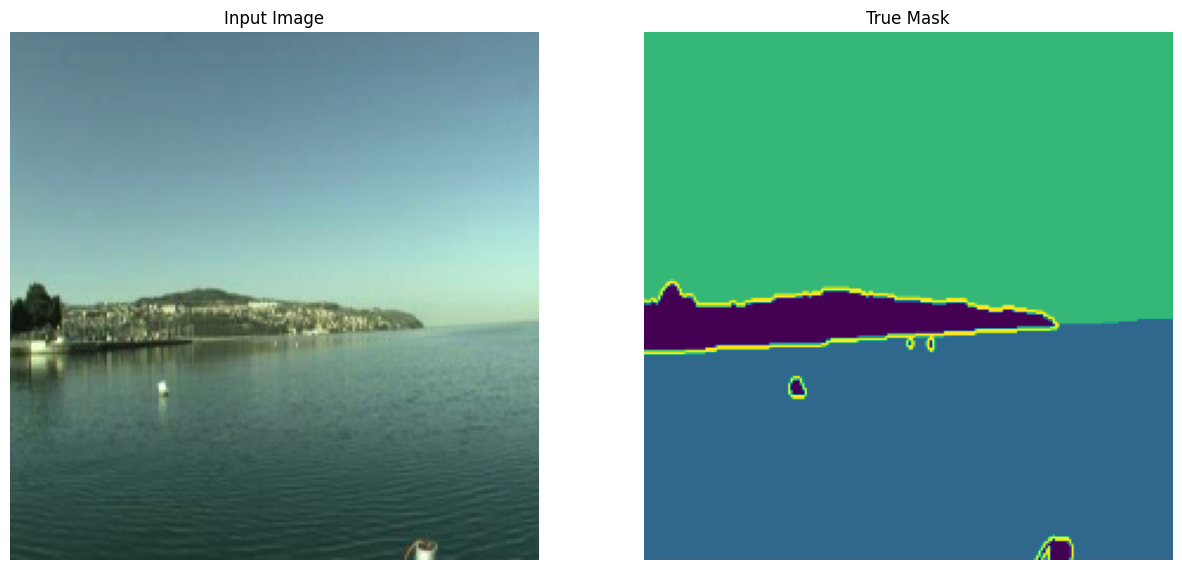

In [35]:
def show_predictions(dataset=None, num=1, show_sample=False, merge=False):
  '''
  For a given dataset plots one image, its true mask, and predicted mask

  Args
  ----------
  dataset (optional): tf.dataset object, defaults first image in testing set
  num (optional): int
  sample (optional): bool: if True, display prediction for sample image

  Returns
  ----------
  Nothing, graph will be displayed

  '''
  batches = num//BATCH_SIZE + 1 # How many batches 
  remainder = num%BATCH_SIZE
  if show_sample:
    display([sample_image, sample_mask, create_mask(model.predict(sample_image[tf.newaxis, ...]))], merge=merge) 
    return
  if dataset and (Make_Preframes or Use_Preframes):
    for image_seq, mask_seq in dataset.take(batches):
      pred_mask = model.predict(image_seq[remainder][tf.newaxis, ...])
      image = image_seq[:,-1] # If using image sequences take the last one
      mask = mask_seq
    display([image[remainder], mask[remainder], create_mask(pred_mask)], merge=merge)
  elif dataset:
    for image, mask in dataset.take(batches):
      pred_mask = model.predict(image[remainder][tf.newaxis, ...])
    display([image[remainder], mask, create_mask(pred_mask)], merge=merge)
  else:
    for image, mask in test_ds.take(batches):
      pred_mask = model.predict(image[remainder][tf.newaxis, ...])
    display([image[remainder], mask[remainder], create_mask(pred_mask)], merge=merge)

for images, masks in val_ds.take(1):
  sample_image, sample_mask = images[0], masks[0] 

if Use_Preframes or Make_Preframes:
  display([sample_image[-1], sample_mask]) # careful, the display function is built in and redefined above TODO
else:
  display([sample_image, sample_mask])

### Shoreline Eval functions

In [36]:
def MODD2_shoreline_eval_single_image(gt_mask, pred_mask):

  '''
  Calculates the RMSE of horizon detection for a single image

  Args:
  ---------
  gt_mask: numpy.array (128, 128, 1)
  pred_mask: numpy.array (128, 128, 1)

  Returns:
  --------
  rmse: int
    (normalized) root mean square error of a single image
  '''

  HEIGHT = len(gt_mask)
  WIDTH = len(gt_mask[0, :])
  gt_len = 1

  diffs = np.empty(WIDTH) # new empty numpy array of width
  for i in range(WIDTH): # For width
    # print(gt_mask[:, i])
    # print(pred_mask[:, i])
    for j, val in enumerate(gt_mask[:, i]): # creates numbered list containing iteration index and corresponding value
      if val == 1:
        gt_len += 1
        break
    for k, val in enumerate(pred_mask[:, i]):
      if val == 1:
        break
    # if no detection along column, assume detection is at bottom of the image
    diffs[i] = abs(j - k)/HEIGHT
    # overflow occurs because of np division, shouldn't affect performance
    rmse = np.sqrt((sum(diffs)**2))/gt_len
  return rmse

# tic = time.perf_counter()
# gt_mask = sample_mask.numpy()
# pred_mask = create_mask(model.predict(sample_image[tf.newaxis, ...])).numpy()
# toc = time.perf_counter()
# print(f"preparing: {toc - tic:0.4f} seconds")

# tic = time.perf_counter()
# MODD2_shoreline_eval_single_image(gt_mask, pred_mask)
# toc = time.perf_counter()
# print(f"RMSE: {toc - tic:0.4f} seconds")

In [37]:
def MODD2_shoreline_eval(ds='test'):
  '''
  Returns score for the MODD2 evaluation of shoreline

  From MODD2 github page:
    For each pixel column in the full-sized image, a distance between water edge, 
    as given by the ground truth and as determined by the algorithm, is calculated. 
    These values are summarised into a single value by averaging across all 
    columns, frames and sequences.

  Args: 
  ----------
  ds: tf.dataset
    dataset object (either train_ds, val_ds, or test_ds)

  Returns:
  ----------
  (mean, std): tuple
    the mean and std for difference between prediction and gt
  '''
  if ds == 'test':
    ds_length = TEST_SIZE
    ds = test_ds
  elif ds == 'train':
    ds_length = TRAINSET_SIZE
    ds = train_ds
  elif ds == 'val':
    ds_length = VALSET_SIZE
    ds = val_ds
  elif ds == 'eval':
    ds_length = EVAL_SIZE
    ds = eval_ds
  else:
    print('Please input valid dataset name (either train, val, or test)')
    raise ValueError()

  num_batches = ds_length // BATCH_SIZE + 1

  # Loop through batches
  RMSEs = []
  for images, labels in tqdm(ds.take(num_batches)):
    preds = model.predict(images)
    # Loop through images within a batch:
    for i, label in enumerate(labels):
      # Have to convert to numpy, iterating through tensor is very slow
      gt_label = label.numpy()
      pred_label = create_mask(preds[i][tf.newaxis, ...]).numpy()

      RMSE = MODD2_shoreline_eval_single_image(gt_label, pred_label)
      RMSEs.append(RMSE)
  return RMSEs

### Training

**Custom loss function**

In the MasTr dataset, the edges of regions are labelled with class 4. The researchers took these regions as 'ambiguous' regions and ignore it. 

The loss function therefore need to ignore the pixels containing class 4

Problem: losing a lot of pixels 

In [38]:
UNLABELLED = 3.0 # Unknown regions are labelled 3

def custom_SparseCategoricalCrossentropy(y_true, y_pred): # Preprocess for unlabelled regions before applying sparse categorial crossentropy loss function
  haslabel = tf.squeeze((y_true != UNLABELLED), axis=-1) 
  y_true = tf.boolean_mask(y_true, haslabel)
  y_pred = tf.boolean_mask(y_pred, haslabel)

  return tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred, from_logits=True, axis=-1)

def custom_sigmoid_focal_crossentropy(y_true, y_pred): # Ignore ambiguous
  haslabel = tf.squeeze((y_true != UNLABELLED), axis=-1)
  y_true = tf.boolean_mask(y_true, haslabel)
  y_true = tf.squeeze(tf.one_hot(tf.cast(y_true, dtype='int32'), depth = 3, axis = 2))
  y_pred = tf.boolean_mask(y_pred, haslabel)

  return tfa.losses.sigmoid_focal_crossentropy(y_true, y_pred, from_logits=True)

def custom_SparseCategoricalCrossentropyLAST(y_true, y_pred): # Alternative loss function for image sequence where only the last one has a mask CURRENTLY UNUSED/EXPERIMENT
  haslabel = tf.squeeze((y_true != UNLABELLED), axis=-1) 
  haslabel = haslabel[-1,:,:]
  y_true = y_true[-1,:,:,:]
  y_pred = y_pred[-1,:,:,:]
  y_true = tf.boolean_mask(y_true, haslabel)
  y_pred = tf.boolean_mask(y_pred, haslabel)
  return tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred, from_logits=True, axis=-1)

In [39]:
def count_num_unlabelled():
  sum = 0
  for images, labels in val_ds.take(VALSET_SIZE//BATCH_SIZE+1): # Take images, labels
    for image, y_true in zip(images, labels):
      y_true = y_true[tf.newaxis, ...]
      haslabel = tf.squeeze((y_true != UNLABELLED), axis=-1)
      y_true = tf.boolean_mask(y_true, haslabel) # Ignore ambiguous
      y_true = tf.squeeze(tf.one_hot(tf.cast(y_true, dtype='int32'), depth = 3, axis = 2))
      sum += 1-len(y_true)/(224*224)
  return sum/VALSET_SIZE

# Display fraction of labelled pixels, indicate how much data we lose in edge regions
print(1 - count_num_unlabelled())


0.9828671993501793


**Callbacks**

- `cp_callback`: saves the best checkpoint weight based on validation loss
- `tensorboard_callback`: writes results to tensorboard
- `rsme_callback`: computes rmse on eval and val set every 5 epochs, writes to tensorboard

In [40]:
# TENSORBOARD CALLBACK
%load_ext tensorboard

# Clear any logs from previous runs
!rm -rf ./logs/
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") # Name log by time and date of running

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1) # Visualisations in the log dir

checkpoint_path = "training_checkpoints/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

try:
  os.mkdir(checkpoint_dir) # Make checkpoint directory
except:
  pass

# CHECKPOINT CALLBACK
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path+'2',
                                                 save_weights_only=True,
                                                 save_best_only = True,
                                                 monitor = 'val_accuracy',
                                                 verbose=1)

# RMSE CALLBACK
rmse_writer = tf.summary.create_file_writer(log_dir)

class RMSE_callback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs = None):
      if epoch%5 == 0: # Every 5th epoch
        mean = np.mean(MODD2_shoreline_eval()) # Mean RMSE test
        mean_val = np.mean(MODD2_shoreline_eval('val')) # Mean val
        with rmse_writer.as_default():
          tf.summary.scalar('RMSE_eval', mean, step=epoch) # Write summaries to log
          tf.summary.scalar('RMSE_val', mean_val, step=epoch)
        print('Test RMSE: {}'.format(mean))
        print('Val  RMSE: {}'.format(mean_val))

rmse_callback = RMSE_callback()

**Instantiate model or load model**

In [42]:
# Retrieve model from drive 
tf.keras.backend.clear_session() # Clear the state and frees up memory
modelname = 'SNet_focal_dropout_600e.zip'
model_path = drive_path + '/saved_models/' + modelname
!unzip $model_path -d 'trained_model'
modelname_nozip = 'SNet_focal_dropout_600e'
model = tf.keras.models.load_model('/content/trained_model/' + modelname_nozip, custom_objects={'custom_sigmoid_focal_crossentropy': custom_sigmoid_focal_crossentropy})
# model = tf.keras.models.load_model('/content/trained_model/' + modelname_nozip, custom_objects={'custom_SparseCategoricalCrossentropy': custom_SparseCategoricalCrossentropy})

modelname = 'ConvLSTM_Deep_1478_1preframes_01dropout_focalLoss_batchnorm_LongLearn_model'
model.save_weights(checkpoint_path+ modelname)

Archive:  /content/drive/MyDrive/3rd_year_project_UCL/saved_models/SNet_focal_dropout_600e.zip
   creating: trained_model/SNet_focal_dropout_600e/
   creating: trained_model/SNet_focal_dropout_600e/variables/
  inflating: trained_model/SNet_focal_dropout_600e/variables/variables.index  
  inflating: trained_model/SNet_focal_dropout_600e/variables/variables.data-00000-of-00001  
  inflating: trained_model/SNet_focal_dropout_600e/saved_model.pb  
   creating: trained_model/SNet_focal_dropout_600e/assets/


In [ ]:
# Insert LSTM in existing model
modelname = 'SNet_focal_dropout_600e.zip'
model_path = drive_path + '/saved_models/' + modelname
!unzip $model_path -d 'trained_model'

modelname_nozip = 'SNet_focal_dropout_600e'
initial_model = tf.keras.models.load_model('/content/trained_model/' + modelname_nozip, custom_objects={'custom_sigmoid_focal_crossentropy': custom_sigmoid_focal_crossentropy})

#adding all the layers from the architecture into a list
layers = [l for l in initial_model.layers]

# Define Layers for LSTM
Batch_input = tf.keras.layers.Input(shape =(Num_Preframes+1, 224, 224, 3))

ConvLSTM = tf.keras.layers.ConvLSTM2D(filters=320, kernel_size=(3, 3),
                                        data_format='channels_last',
                                        activation='tanh',
                                        padding='same', return_sequences=False)
  
Batch_Norm = tf.keras.layers.BatchNormalization()

# k needed for correctly adding skip connections
k = 2
x = layers[0].output
for i in range(1, len(layers)):
    if i == 2: # if at the deepest layer
      outputs = []
      # Time distributed as when building models from the ground up
      for out in x:
        outputs.append(tf.keras.layers.TimeDistributed(tf.keras.Model(initial_model.input, out))(Batch_input)) 
      for j in range(len(outputs[:-1])):
        outputs[j] = tf.keras.layers.Lambda(get_last_timestep, output_shape=lambda s: s[:1] + s[2:])(outputs[j])
      Time_model2 = tf.keras.Model(inputs=Batch_input, outputs=outputs)

      # Add æayers and skip connections
      skips2 = Time_model2(Batch_input)
      x = skips2[-1] # Last layer
      x = ConvLSTM(x)
      x = Batch_Norm(x)
      outputs.reverse()
    if isinstance(layers[i].input, list): # Only for skip connections
      x = layers[i]([x,skips2[-k]])
      k = k+1
    else:
      x = layers[i](x)

# Define moel
model = tf.keras.Model(inputs=Batch_input, outputs=x)

# Define learn rate scheduler
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-5,
    decay_steps=2000,
    decay_rate=0.60)

# Compile
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate = lr_schedule),
              loss=custom_sigmoid_focal_crossentropy, #custom_sigmoid_focal_crossentropy,
              metrics=['accuracy'])

modelname = 'ConvLSTM_Deep_1478_1preframes_01dropout_focalLoss_batchnorm_LongLearn.zip'

In [ ]:
# Non-LSTM (ShorelineNet)
model = unet_model(output_channels=N_CLASSES) # Instantiate new model
model.compile(optimizer=tf.keras.optimizers.RMSprop(), # Compile
              loss=custom_sigmoid_focal_crossentropy, #custom_sigmoid_focal_crossentropy,custom_SparseCategoricalCrossentropy
              metrics=['accuracy'])
modelname = '224x224_ShorelineNet_standard_focalLoss_1478.zip'

In [ ]:
# LSTM end

# Define required layers
ConvLSTM_end = tf.keras.layers.ConvLSTM2D(filters=3, kernel_size=(3, 3),
                                        data_format='channels_last',
                                        activation='tanh',
                                        padding='same', return_sequences=False,
                                        dropout = 0.1)
Batch_Norm = tf.keras.layers.BatchNormalization()

# Create model applied to only a single frame
model_singleframe = unet_model_LSTM_end(output_channels=N_CLASSES)

# Apply timedistributed wrapper
Batch_input = tf.keras.layers.Input(shape =(Num_Preframes+1, 224, 224, 3))
outputs = tf.keras.layers.TimeDistributed(model_singleframe)(Batch_input)

# Add convLSTM layer
outputs = ConvLSTM_end(outputs)
outputs = Batch_Norm(outputs)

model = tf.keras.Model(inputs=Batch_input, outputs=outputs)

# Learning rate scheduler
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=2000,
    decay_rate=0.80)

# Compile
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate = lr_schedule),
              loss=custom_sigmoid_focal_crossentropy, #custom_sigmoid_focal_crossentropy,custom_SparseCategoricalCrossentropy
              metrics=['accuracy'])
modelname = 'ConvLSTM_end_1478_1preframe_01dropout_focalLoss_batchnorm_lrschedule.zip'

In [ ]:
# LSTM deep
# Single convLSTM layer at the deepest level of the model
model = unet_model_LSTM_deep(output_channels=N_CLASSES) # Instantiate new model

# Learning rate scheduler
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=2000,
    decay_rate=0.80)

# Compile
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate = lr_schedule),
              loss=custom_sigmoid_focal_crossentropy, #custom_sigmoid_focal_crossentropy,
              metrics=['accuracy'])
modelname = 'ConvLSTM_Deep_1478_1preframes_0301dropout_focalLoss_batchnorm.zip'

In [ ]:
# LSTM deep and end

# Define layers
ConvLSTM_end = tf.keras.layers.ConvLSTM2D(filters=3, kernel_size=(3, 3),
                                        data_format='channels_last',
                                        activation='tanh',
                                        padding='same', return_sequences=False,
                                        dropout = 0.1)

Batch_Norm = tf.keras.layers.BatchNormalization()

# Lad multi frame model with convLSTM at the deepest level
model_multiframe = unet_model_LSTM_deepend(output_channels=N_CLASSES)

# Add convLSTM at the end
outputs = ConvLSTM_end(model_multiframe.output)
outputs = Batch_Norm(outputs)

# Full model
model = tf.keras.Model(inputs=model_multiframe.input, outputs=outputs)

# Learning rate scheduler
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=2000,
    decay_rate=0.80)

model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate = lr_schedule),
              loss=custom_sigmoid_focal_crossentropy, #custom_sigmoid_focal_crossentropy,custom_SparseCategoricalCrossentropy
              metrics=['accuracy'])
modelname = 'ConvLSTM_deepend_1478_1preframe_01dropout_batchnorm_lrSchedule_focalLoss.zip'

In [ ]:
# LSTM skip

# ConvLSTM in all endcoder-decoder connections
model = unet_model_LSTM_skip(output_channels=N_CLASSES) # Instantiate new model

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=2000,
    decay_rate=0.80)

model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate = lr_schedule),
              loss=custom_sigmoid_focal_crossentropy, #custom_sigmoid_focal_crossentropy,
              metrics=['accuracy'])
modelname = 'ConvLSTM_Skip_1478_1preframe_01dropout_focalLoss_batchnorm_lrschedule.zip'

In [ ]:
# LSTM skip and end

# Maximum number of convLSTM blocks in all encoder-decoder connections and at the end

# Layers
ConvLSTM_end = tf.keras.layers.ConvLSTM2D(filters=3, kernel_size=(3, 3),
                                        data_format='channels_last',
                                        activation='tanh',
                                        padding='same', return_sequences=False,
                                        dropout = 0.1)

Batch_Norm = tf.keras.layers.BatchNormalization()

# Create model and add convLSTM at end
model_multiframe = unet_model_LSTM_skipend(output_channels=N_CLASSES)
outputs = ConvLSTM_end(model_multiframe.output)
outputs = Batch_Norm(outputs)

model = tf.keras.Model(inputs=model_multiframe.input, outputs=outputs)

# Learning rate scheduler
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=2000,
    decay_rate=0.80)

model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate = lr_schedule),
              loss=custom_sigmoid_focal_crossentropy, #custom_sigmoid_focal_crossentropy,custom_SparseCategoricalCrossentropy
              metrics=['accuracy'])
modelname = 'ConvLSTM_skipend_1478_1preframe_01dropout_batchnorm_lrSchedule_focalLoss.zip'

In [ ]:
# Plot model to ensure connections are correct
tf.keras.utils.plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
# Summarise model and check number of parameters
model.summary()

In [44]:
# Check that everything is loaded properly
show_predictions(show_sample=True) # Use when using only a single image
# show_predictions(dataset=val_ds) # Use when using preframes

ValueError: ignored

In [ ]:
# Load tensorboard widget
%tensorboard --logdir logs/fit

In [ ]:
# Train the model
EPOCHS = 200
STEPS_PER_EPOCH = TRAINSET_SIZE // BATCH_SIZE
VALIDATION_STEPS = VALSET_SIZE // BATCH_SIZE

model_history_2 = model.fit(train_ds, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          callbacks=[cp_callback, tensorboard_callback],
                          validation_steps=VALIDATION_STEPS,
                          validation_data=val_ds)


In [ ]:
model.save_weights(checkpoint_path+'longlearn')

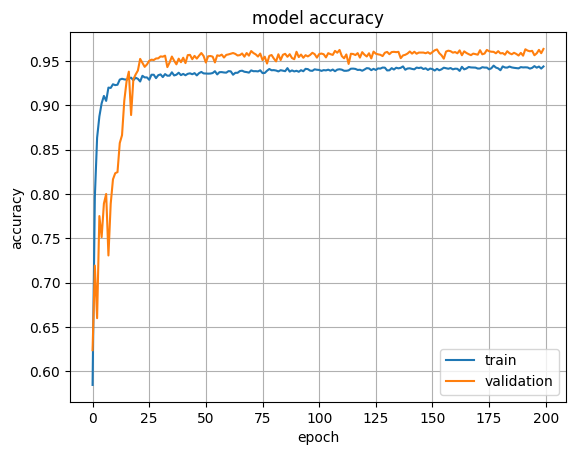

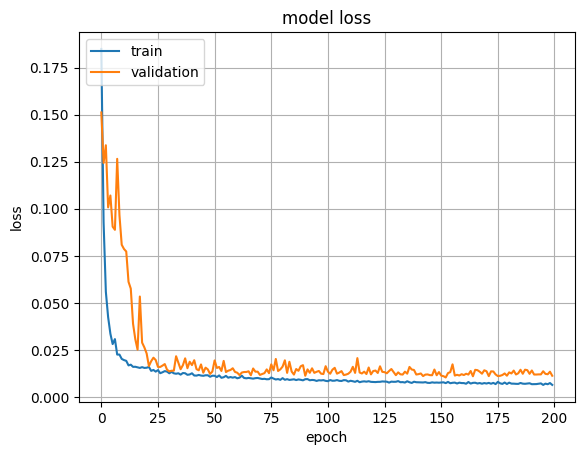

In [ ]:
# summarize history for accuracy
plt.plot(model_history_2.history['accuracy'])
plt.plot(model_history_2.history['val_accuracy'])
plt.title('model accuracy')
plt.grid()
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower right')
plt.show()
# summarize history for loss
plt.plot(model_history_2.history['loss'])
plt.plot(model_history_2.history['val_loss'])
plt.title('model loss')
plt.grid()
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
# Load best model from checkpoints
model.load_weights(checkpoint_path + '2')

## RMSEs using MODD2 for a preliminary indication of performance

In [ ]:
# Calculate RMSEs
RMSEs_test, RMSEs_val, RMSEs_train, RMSEs_eval = 0, 0, 0, 0

RMSEs_test = MODD2_shoreline_eval()

mean = np.mean(RMSEs_test)
std = np.std(RMSEs_test)
print(mean, std)

In [ ]:
# Calculate RMSEs
RMSEs_eval = MODD2_shoreline_eval('eval')

mean = np.mean(RMSEs_eval)
std = np.std(RMSEs_eval)
print(mean, std)

In [ ]:
RMSEs_val = MODD2_shoreline_eval('val')

mean = np.mean(RMSEs_val)
std = np.std(RMSEs_val)
print(mean, std)

In [ ]:
RMSEs_train = MODD2_shoreline_eval('train')

mean = np.mean(RMSEs_train)
std = np.std(RMSEs_train)
print(mean, std)

In [ ]:
# Create summary of MODD2 RMSE Performance

list_summary = []

list_summary.append([TRAINSET_SIZE, np.mean(RMSEs_train), np.std(RMSEs_train), np.mean(RMSEs_train) * 958])
list_summary.append([VALSET_SIZE, np.mean(RMSEs_val), np.std(RMSEs_val), np.mean(RMSEs_val) * 958])
list_summary.append([TEST_SIZE, np.mean(RMSEs_test), np.std(RMSEs_test), np.mean(RMSEs_test) * 958])
list_summary.append([EVAL_SIZE, np.mean(RMSEs_eval), np.std(RMSEs_eval), np.mean(RMSEs_eval) * 958])


df_summary = pd.DataFrame(data=list_summary, columns=['no.imgs', 'mean', 'std', 'mean-px'], index=['train', 'val', 'test', 'eval'])

df_summary

## Qualitative performance on MODD2

In [ ]:
# Test images
# 27_128 (reflection)         take(3)
# 27_256 (building)           take(5)
# 27_384 (big wall right)     take(7)
# 27_448 (big wall mid)       take(8)
# 27_512 (big wall left)      take(9)
# --------------------------- (total 671 images)
# 28_33 (standard)            take(12)
# 28_417 (wall mid)           take(18)
# 28_609 (hazy)               take(21)

In [45]:
# Show tests

index = 40

# test_ds.skip(6)
for image, mask in test_ds.take(10):
  display_image, display_mask = image[index], mask[index]

pred_mask = model.predict(display_image[tf.newaxis, ...])
pred_mask = create_mask(pred_mask)
if Use_Preframes or Make_Preframes:
  display([display_image[-1], display_mask, pred_mask])
else:
  display([display_image, display_mask, pred_mask])


ValueError: ignored

# **Results** 

In [ ]:
# Clear results folder if needed
# result_dir = '/content/results'
# import shutil
# shutil.rmtree(result_dir) 

### MODS </br>

*Path:* </br>
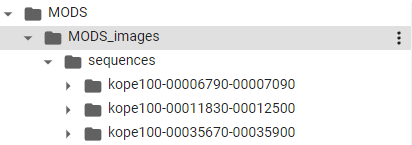

In [47]:
# Count number of folders in a directory
def count_folders(dir):
    return len([f for f in os.listdir(dir) if os.path.isdir(os.path.join(dir, f))])


In [ ]:
# Set modelname if not already defined or loaded
if 'modelname' in locals():
  print('Model Name for saving in results dir: ', modelname[:-4])
else:
  modelname = 'Test_Model_results_LSTM'

# Set directory to MODS
MODS_dir = '/content/MODS'
MODS_image_dir = os.path.join(MODS_dir, 'MODS_images','sequences')

# Get number of sequences and their names
Seq_count = count_folders(MODS_image_dir)
Seq_Names = os.listdir(MODS_image_dir)

print("Number of sequence folders: {}".format(Seq_count))

result_dir = '/content/results'

# Make results directory
if not os.path.isdir(result_dir):
  os.mkdir(os.path.join(os.getcwd(), 'results'))

# Name of the model for saving location
method_dir = os.path.join(result_dir, modelname[:-4])
if not os.path.isdir(method_dir):
  os.mkdir(method_dir)
  for i in range(Seq_count):
    output_dir = os.path.join(method_dir, Seq_Names[i])
    os.mkdir(output_dir)

Model Name for saving in results dir:  ConvLSTM_Deep_1478_1preframes_01dropout_focalLoss_batchnorm_LongLearn
Number of sequence folders: 94






```
RGB of prediction mask:
[0, 0, 0]# Obstacle
[1, 1, 1]# Water
[2, 2, 2]# Sky
```



In [ ]:
# For MODS predictions apply sliding window to all sequences to take image and pre-frames as input into model
for i in range(Seq_count): # Each sequence
  seq_foldername = Seq_Names[i]
  seq_filepath = os.path.join(MODS_image_dir, seq_foldername,'frames')
  print(f'detecting results for {seq_foldername}...')
  im_array = []

  for image in tqdm(sorted(os.listdir(seq_filepath))):
    if image.endswith('L.jpg'): # Only predict on left picture of stereo images
      filename = image[:-4]
      filepath = os.path.join(seq_filepath, image)
      out_filepath = os.path.join(result_dir, method_dir, seq_foldername, filename + '.png')
      image = pimage.open(filepath)
      image = image.resize((224, 224))
      image_np = np.asarray(image)/255
      image_tensor = tf.convert_to_tensor(image_np)

      im_array.append(image_np) # List of images in sequence
      if Make_Preframes or Use_Preframes:  # Take pre-frames, if not enough are available take copies of current frame
        if len(im_array)>Num_Preframes:
          pre_images = im_array[-Num_Preframes:]
        else:
          pre_images = np.zeros((Num_Preframes,224, 224,3))
          num_true = np.max([0,len(im_array)- Num_Preframes])
          for j in range(Num_Preframes):
            pre_images[j] = im_array[-1]

          for j in range(num_true):
            pre_images[j] = im_array[-(Num_Preframes-j)]

        pre_image_tensor = tf.convert_to_tensor(pre_images)
        image_tensor = tf.expand_dims(image_tensor, axis=0)
        image_tensor = tf.concat((pre_image_tensor, image_tensor), axis=0)
      
      # Predice
      pred_mask = model.predict(image_tensor[tf.newaxis, ...])
      pred_mask = tf.squeeze(create_mask(pred_mask))
      
      pred_mask_np = pred_mask.numpy()
      pred_mask_np = np.repeat(np.expand_dims(pred_mask_np, axis=2), 3, axis=2)
      pred_mask_image = pimage.fromarray(pred_mask_np.astype(np.uint8), 'RGB')
      pred_mask_image = pred_mask_image.resize((512, 384))
      pred_mask_image.save(out_filepath) # Save to file path for given sequence

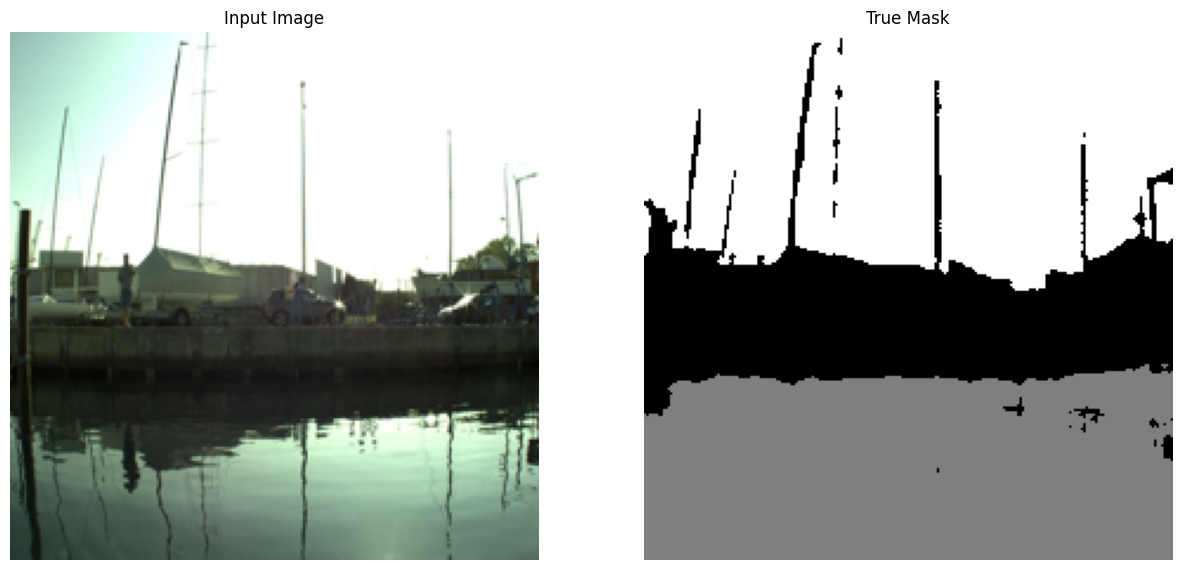

In [ ]:
# Show test image
test_img = pimage.fromarray(pred_mask_np.astype(np.uint8))
display([image_np, test_img])


In [ ]:
# Download results files
!zip -r ConvLSTM_Deep_1478_1preframes_01dropout_focalLoss_batchnorm_LongLearn.zip /content/results/ConvLSTM_Deep_1478_1preframes_01dropout_focalLoss_batchnorm_LongLearn

MODS raw

In [53]:
sequence = "kope101-00060000-00060400"
Path = "/content/drive/MyDrive/3rd_year_project_UCL/dataset/kope101-00060000-00060400/frames"

In [54]:
sequence = "kope101-00060000-00060400"

# Set modelname if not already defined or loaded
if 'modelname' in locals():
  print('Model Name for saving in results dir: ', modelname[:-4])
else:
  modelname = 'Test_Model_results_LSTM'

# Set directory to MODS
MODS_dir = '/content/MODS'
MODS_image_dir = os.path.join(MODS_dir, 'MODS_images','sequences')

# Get number of sequences and their names
Seq_count = 1
Seq_Names = sequence

print("Number of sequence folders: {}".format(Seq_count))

result_dir = '/content/results'

# Make results directory
if not os.path.isdir(result_dir):
  os.mkdir(os.path.join(os.getcwd(), 'results'))

# Name of the model for saving location
method_dir = os.path.join(result_dir, modelname[:-4])
if not os.path.isdir(method_dir):
  os.mkdir(method_dir)
  for i in range(Seq_count):
    output_dir = os.path.join(method_dir, Seq_Names[i])
    os.mkdir(output_dir)

Model Name for saving in results dir:  ConvLSTM_Deep_1478_1preframes_01dropout_focalLoss_batchnorm_LongLearn_m
Number of sequence folders: 1


In [55]:
# For MODS predictions apply sliding window to all sequences to take image and pre-frames as input into model
for i in range(Seq_count): # Each sequence
  seq_foldername = Seq_Names[i]
  seq_filepath = "/content/drive/MyDrive/3rd_year_project_UCL/dataset/kope101-00060000-00060400/frames"
  print(f'detecting results for {seq_foldername}...')
  im_array = []

  for image in tqdm(sorted(os.listdir(seq_filepath))):
    if image.endswith('L.jpg'): # Only predict on left picture of stereo images
      filename = image[:-4]
      filepath = os.path.join(seq_filepath, image)
      out_filepath = os.path.join(result_dir, method_dir, seq_foldername, filename + '.png')
      image = pimage.open(filepath)
      image = image.resize((224, 224))
      image_np = np.asarray(image)/255
      image_tensor = tf.convert_to_tensor(image_np)

      im_array.append(image_np) # List of images in sequence
      if Make_Preframes or Use_Preframes:  # Take pre-frames, if not enough are available take copies of current frame
        if len(im_array)>Num_Preframes:
          pre_images = im_array[-Num_Preframes:]
        else:
          pre_images = np.zeros((Num_Preframes,224, 224,3))
          num_true = np.max([0,len(im_array)- Num_Preframes])
          for j in range(Num_Preframes):
            pre_images[j] = im_array[-1]

          for j in range(num_true):
            pre_images[j] = im_array[-(Num_Preframes-j)]

        pre_image_tensor = tf.convert_to_tensor(pre_images)
        image_tensor = tf.expand_dims(image_tensor, axis=0)
        image_tensor = tf.concat((pre_image_tensor, image_tensor), axis=0)
      
      # Predice
      pred_mask = model.predict(image_tensor[tf.newaxis, ...])
      pred_mask = tf.squeeze(create_mask(pred_mask))
      
      pred_mask_np = pred_mask.numpy()
      pred_mask_np = np.repeat(np.expand_dims(pred_mask_np, axis=2), 3, axis=2)
      pred_mask_image = pimage.fromarray(pred_mask_np.astype(np.uint8), 'RGB')
      pred_mask_image = pred_mask_image.resize((512, 384))
      pred_mask_image.save(out_filepath) # Save to file path for given sequence

detecting results for k...


  0%|          | 0/802 [00:00<?, ?it/s]

1/1 [==============================] - 0s 30ms/step


In [56]:
# Download results files
!zip -r fullmodskope101-00060000-00060400.zip /content/results/ConvLSTM_Deep_1478_1preframes_01dropout_focalLoss_batchnorm_LongLearn_m

  adding: content/results/ConvLSTM_Deep_1478_1preframes_01dropout_focalLoss_batchnorm_LongLearn_m/ (stored 0%)
  adding: content/results/ConvLSTM_Deep_1478_1preframes_01dropout_focalLoss_batchnorm_LongLearn_m/k/ (stored 0%)
  adding: content/results/ConvLSTM_Deep_1478_1preframes_01dropout_focalLoss_batchnorm_LongLearn_m/k/00060266L.png (deflated 64%)
  adding: content/results/ConvLSTM_Deep_1478_1preframes_01dropout_focalLoss_batchnorm_LongLearn_m/k/00060398L.png (deflated 72%)
  adding: content/results/ConvLSTM_Deep_1478_1preframes_01dropout_focalLoss_batchnorm_LongLearn_m/k/00060177L.png (deflated 62%)
  adding: content/results/ConvLSTM_Deep_1478_1preframes_01dropout_focalLoss_batchnorm_LongLearn_m/k/00060241L.png (deflated 62%)
  adding: content/results/ConvLSTM_Deep_1478_1preframes_01dropout_focalLoss_batchnorm_LongLearn_m/k/00060300L.png (deflated 59%)
  adding: content/results/ConvLSTM_Deep_1478_1preframes_01dropout_focalLoss_batchnorm_LongLearn_m/k/00060150L.png (deflated 62%)
  

### MODD2

In [ ]:
result_dir = '/content/results'
sequence_dirs = []

# Make folders
try:
  os.mkdir(os.path.join(os.getcwd(), 'results'))
  for i in range(28):
    sequence_dir = os.path.join(result_dir, f'seq{i+1:02d}')
    output_dir = os.path.join(sequence_dir, 'Unet')
    sequence_dirs.append(sequence_dir)
    os.mkdir(sequence_dir)
    os.mkdir(output_dir)
except:
  print('error raised')

In [ ]:
eval_dir = '/content/eval_data'
eval_image_dir = os.path.join(eval_dir, 'images')

for i in range(28):
  seq_foldername = f'seq{i+1:02d}'
  seq_filepath = os.path.join(eval_image_dir, seq_foldername)
  print(f'detecting results for {seq_foldername}...')
  for image in tqdm(sorted(os.listdir(seq_filepath))):
    if image.endswith('.jpg'):
      filename = image[:-4]
      filepath = os.path.join(seq_filepath, image)
      out_filename = filename + '_pred'
      out_filepath = os.path.join(result_dir, seq_foldername, out_filename + '.png')

      image = pimage.open(filepath)
      image = image.resize((224, 224))
      image_np = np.asarray(image)/255
      image_tensor = tf.convert_to_tensor(image_np)

      pred_mask = model.predict(image_tensor[tf.newaxis, ...])
      pred_mask = tf.squeeze(create_mask(pred_mask))
      
      pred_mask_np = pred_mask.numpy()
      pred_mask_np = np.repeat(np.expand_dims(pred_mask_np, axis=2), 3, axis=2)
      pred_mask_image = pimage.fromarray(pred_mask_np.astype(np.uint8), 'RGB')
      pred_mask_image = pred_mask_image.resize((512, 384))
      # print(out_filepath)
      pred_mask_image.save(out_filepath)

detecting results for seq01...



detecting results for seq02...



detecting results for seq03...



detecting results for seq04...



detecting results for seq05...



detecting results for seq06...



detecting results for seq07...



detecting results for seq08...



detecting results for seq09...



detecting results for seq10...



detecting results for seq11...



detecting results for seq12...



detecting results for seq13...



detecting results for seq14...



detecting results for seq15...



detecting results for seq16...



detecting results for seq17...



detecting results for seq18...



detecting results for seq19...



detecting results for seq20...



detecting results for seq21...



detecting results for seq22...



detecting results for seq23...



detecting results for seq24...



detecting results for seq25...



detecting results for seq26...



detecting results for seq27...



detecting results for seq28...


In [ ]:
# Zip and save to drive 
%%bash
cd results
zip -r 'Results_SNet_baseline_600e.zip' . -x '.*' -x '__MACOSX'

  adding: seq08/ (stored 0%)
  adding: seq08/00067761L_pred.png (deflated 50%)
  adding: seq08/00067762L_pred.png (deflated 49%)
  adding: seq08/00067604L_pred.png (deflated 51%)
  adding: seq08/00067804L_pred.png (deflated 55%)
  adding: seq08/00067702L_pred.png (deflated 47%)
  adding: seq08/00067287L_pred.png (deflated 56%)
  adding: seq08/00067400L_pred.png (deflated 52%)
  adding: seq08/00067302L_pred.png (deflated 54%)
  adding: seq08/00067447L_pred.png (deflated 55%)
  adding: seq08/00067558L_pred.png (deflated 48%)
  adding: seq08/00067737L_pred.png (deflated 47%)
  adding: seq08/00067576L_pred.png (deflated 52%)
  adding: seq08/00067510L_pred.png (deflated 49%)
  adding: seq08/00067352L_pred.png (deflated 55%)
  adding: seq08/00067342L_pred.png (deflated 51%)
  adding: seq08/00067477L_pred.png (deflated 57%)
  adding: seq08/00067766L_pred.png (deflated 49%)
  adding: seq08/00067457L_pred.png (deflated 52%)
  adding: seq08/00067828L_pred.png (deflated 50%)
  adding: seq08/00067

In [ ]:
!cp 'results/Results_SNet_baseline_600e.zip' '/content/drive/My Drive/project_online/'

## Export model

In [ ]:
out_filepath = 'ConvLSTM_Deep_1478_1preframes_01dropout_focalLoss_batchnorm_LongLearn_model'
out_zipfile = out_filepath + '.zip'

In [ ]:
model.save(filepath=out_filepath)

In [ ]:
out_filepath = '224x224_LSTM2-128-dropout'
out_zipfile = out_filepath + '.zip'
!zip -r 'ConvLSTM_Deep_1478_1preframes_01dropout_focalLoss_batchnorm_LongLearn_model.zip' 'ConvLSTM_Deep_1478_1preframes_01dropout_focalLoss_batchnorm_LongLearn_model' -x '.*' -x '__MACOSX'
# zip -r '224x224_LSTM2-128-dropout.zip' . -x '.*' -x '__MACOSX'
# zip -r 'Results_SNet_baseline_600e.zip' . -x '.*' -x '__MACOSX'